Starting analysis of log files...
Found 12 log files:
  - /home/antoniob/FederNet/results/time/grpc_iid/grpc_iid_SCAFFOLD_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time/grpc_iid/grpc_iid_fedAvg_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time/grpc_no_iid/grpc_noniid_SCAFFOLD_CS_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time/grpc_no_iid/grpc_noniid_fedAvg_CS_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time/grpc_no_iid/grpc_noniid_SCAFFOLD_NOCS_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time/grpc_no_iid/grpc_noniid_fedAvg_NOCS_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time/mqtt_no_iid/mqtt_noniid_SCAFFOLD_CS_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time/mqtt_no_iid/mqtt_noniid_SCAFFOLD_NOCS_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time/mqtt_no_iid/mqtt_noniid_fedAvg_NOCS_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time/mqtt_no_iid/mqtt_noniid_fedAvg_CS_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/

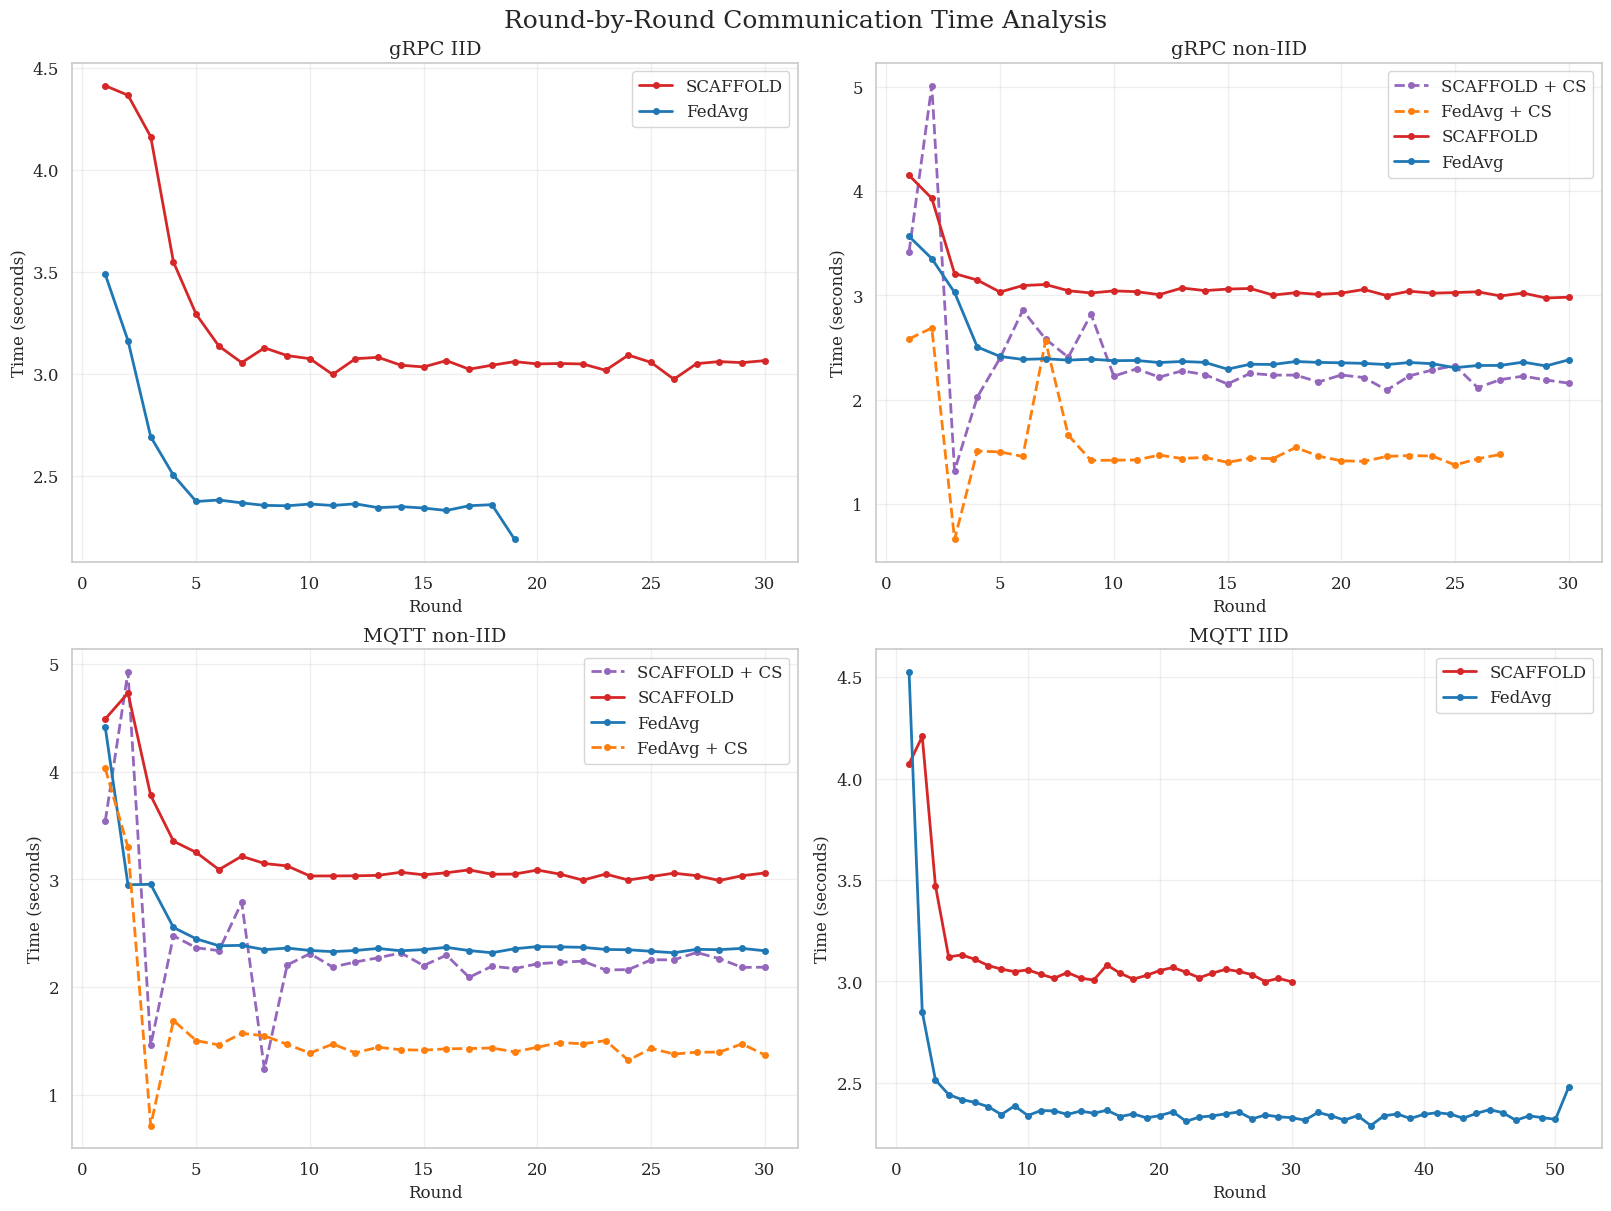

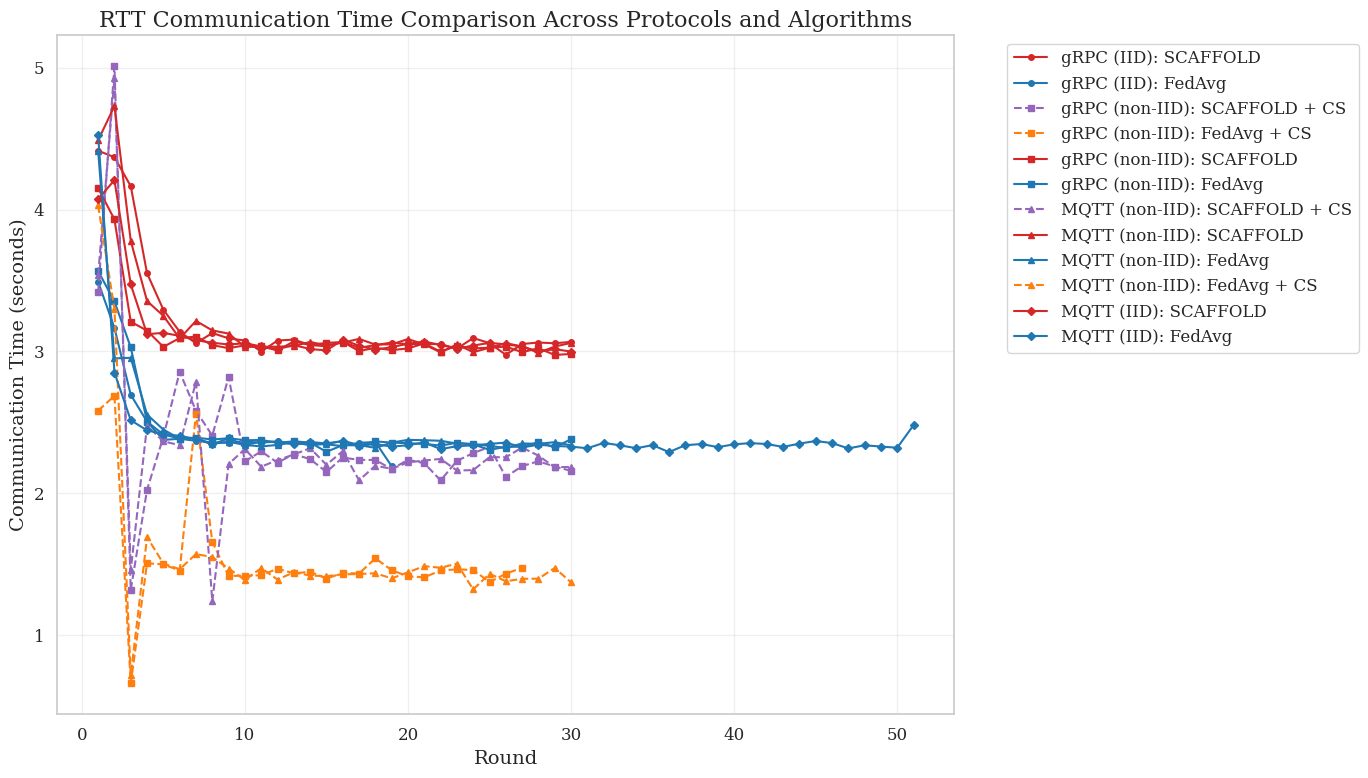

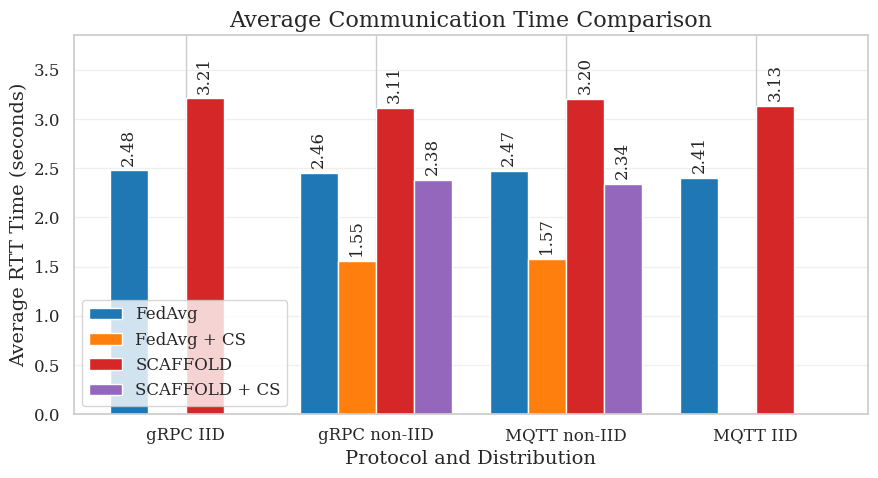

In [144]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import glob
import os
import numpy as np


plt.rcParams.update({
    "font.size": 14,        # base font
    "axes.titlesize": 16,   # subplot / figure titles
    "axes.labelsize": 14,   # x- and y-labels
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

# Base path for log files
base_path = "/home/antoniob/FederNet/results/time"

# Function to extract round-by-round timing data
def extract_round_times(log_file):
    """Extract timing data for each round from a log file"""
    round_times = defaultdict(list)
    try:
        with open(log_file, 'r') as file:
            for line in file:
                match = re.search(r'Round\s+(\d+),\s*time\s+for\s+(.*?)\s+is\s+([\d.]+)', line)
                if match:
                    round_num = int(match.group(1))
                    time_value = float(match.group(3))
                    round_times[round_num].append(time_value)
    except FileNotFoundError:
        print(f"Warning: {log_file} not found")
    except Exception as e:
        print(f"Error reading {log_file}: {e}")
    
    # Calculate average for each round
    round_avg = {}
    for round_num, times in round_times.items():
        if times:
            round_avg[round_num] = sum(times) / len(times)
    
    return round_avg

# Improved function to extract algorithm details from filename
def parse_file_info(filename):
    """Parse filename to extract protocol, algorithm, and distribution details"""
    basename = os.path.basename(filename)
    dirname = os.path.basename(os.path.dirname(filename))
    
    # Debug print to help troubleshoot
    print(f"Processing file: {basename} in directory: {dirname}")
    
    # Try to extract protocol from directory name first, then filename
    protocol = "unknown"
    if "mqtt" in dirname.lower():
        protocol = "MQTT"
    elif "grpc" in dirname.lower():
        protocol = "gRPC"
    elif "mqtt" in basename.lower():
        protocol = "MQTT"
    elif "grpc" in basename.lower():
        protocol = "gRPC"
    
    # Extract distribution from directory name first, then filename
    distribution = "unknown"
    if "iid" in dirname.lower() and "no_iid" not in dirname.lower() and "noniid" not in dirname.lower():
        distribution = "IID"
    elif "no_iid" in dirname.lower() or "noniid" in dirname.lower():
        distribution = "non-IID"
    elif "_iid" in basename.lower() and "noniid" not in basename.lower() and "non_iid" not in basename.lower():
        distribution = "IID"
    elif "noniid" in basename.lower() or "non_iid" in basename.lower() or "no_iid" in basename.lower():
        distribution = "non-IID"
    
    # Extract algorithm - use more flexible detection
    algorithm = "unknown"
    if re.search(r'fedavg|fed_avg', basename.lower()):
        algorithm = "FedAvg"
    elif re.search(r'scaffold', basename.lower()):
        algorithm = "SCAFFOLD"
        
    # Determine client selection status - more comprehensive checks
    has_cs = False
    if "_cs_" in basename.lower() or basename.lower().endswith("_cs") or "_cs." in basename.lower():
        has_cs = True
    elif "nocs" in basename.lower():
        has_cs = False
    
    # Create identifier for the algorithm
    algorithm_id = f"{algorithm}"
    if has_cs:
        algorithm_id += " + CS"
        
    group = f"{protocol} {distribution}"
    
    # Debug output for troubleshooting
    print(f"  → Protocol: {protocol}, Distribution: {distribution}, Algorithm: {algorithm_id}")
    
    return {
        "group": group,
        "algorithm": algorithm_id,
        "protocol": protocol,
        "distribution": distribution,
        "has_cs": has_cs,
        "base_algo": algorithm
    }

# Function to analyze all available logs
def analyze_logs():
    # Get all log files recursively, with more detailed debug output
    log_files = glob.glob(os.path.join(base_path, "**/*.log"), recursive=True)
    print(f"Found {len(log_files)} log files:")
    for f in log_files:
        print(f"  - {f}")
    
    # Collect data organized by group and algorithm
    data = {}
    
    for log_file in log_files:
        file_info = parse_file_info(log_file)
        group = file_info["group"]
        algorithm = file_info["algorithm"]
        
        # Skip unknown protocols or distributions
        if "unknown" in group:
            print(f"Warning: Could not determine protocol or distribution for {log_file}")
            continue
            
        if group not in data:
            data[group] = {}
            
        # Extract timing data
        round_data = extract_round_times(log_file)
        if round_data:
            data[group][algorithm] = round_data
            print(f"Successfully processed: {os.path.basename(log_file)} → {group}/{algorithm}")
        else:
            print(f"Warning: No valid timing data found in {log_file}")
    
    return data

# Create color scheme for algorithms
colors = {
    "FedAvg": '#1f77b4',
    "FedAvg + CS": '#ff7f0e',
    "SCAFFOLD": '#d62728',
    "SCAFFOLD + CS": '#9467bd'
}

# Run the analysis
print("Starting analysis of log files...")
timing_data = analyze_logs()

# Print found data for verification
print("\nData groups found:")
for group, algos in timing_data.items():
    print(f"Group: {group}")
    for algo, data in algos.items():
        print(f"  - {algo}: {len(data)} rounds")

# Continue with your existing visualization code...
# Create multiple plots - one for each protocol+distribution combo
fig, axes = plt.subplots(2, 2, figsize=(16, 12), constrained_layout=True)
axes = axes.flatten()

# Track which axes are used
used_axes = []

# Plot each group in a separate subplot
for i, (group_name, algorithms) in enumerate(timing_data.items()):
    if i >= len(axes):
        print(f"Warning: More groups than available subplots. Skipping {group_name}")
        continue
        
    ax = axes[i]
    used_axes.append(i)
    
    ax.set_title(group_name, fontsize=14)
    
    for algo_name, round_data in algorithms.items():
        rounds = sorted(round_data.keys())
        times = [round_data[r] for r in rounds]
        
        # Determine color and style
        color = colors.get(algo_name, '#000000')
        linestyle = '--' if "+ CS" in algo_name else '-'
        
        # Plot with proper formatting
        ax.plot(rounds, times, linestyle=linestyle, color=color, 
                label=algo_name, linewidth=2, marker='o', markersize=4)
    
    ax.set_xlabel("Round", fontsize=12)
    ax.set_ylabel("Time (seconds)", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')

# Remove any unused axes
for i in range(len(axes)):
    if i not in used_axes:
        fig.delaxes(axes[i])

plt.suptitle("Round-by-Round Communication Time Analysis", fontsize=18)
plt.savefig(os.path.join(base_path, "round_analysis_by_group.png"), dpi=300, bbox_inches='tight')
plt.show()

# Create a combined plot with all data for comparison
plt.figure(figsize=(14, 8))
markers = ['o', 's', '^', 'D', 'x', '+', '*']

for group_idx, (group_name, algorithms) in enumerate(timing_data.items()):
    for algo_name, round_data in algorithms.items():
        rounds = sorted(round_data.keys())
        times = [round_data[r] for r in rounds]
        
        # Determine formatting
        color = colors.get(algo_name, '#000000')
        style = '--' if "+ CS" in algo_name else '-'
        marker = markers[group_idx % len(markers)]
        
        # Create descriptive label
        protocol, distribution = group_name.split(' ')
        label = f"{protocol} ({distribution}): {algo_name}"
        
        plt.plot(rounds, times, linestyle=style, color=color,
                marker=marker, markersize=4, label=label)

plt.xlabel("Round", fontsize=14)
plt.ylabel("Communication Time (seconds)", fontsize=14)
plt.title("RTT Communication Time Comparison Across Protocols and Algorithms", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(base_path, "round_analysis_combined.png"), dpi=300, bbox_inches='tight')
plt.show()

# Calculate and display average times for bar chart comparison
avg_data = {}

for group_name, algorithms in timing_data.items():
    if group_name not in avg_data:
        avg_data[group_name] = {}
    
    for algo_name, round_data in algorithms.items():
        if round_data:
            avg_time = sum(round_data.values()) / len(round_data)
            avg_data[group_name][algo_name] = avg_time

# Create bar chart for average times
plt.figure(figsize=(9, 5))
bar_width = 0.2
group_spacing = 0.1
index = np.arange(len(avg_data))

# Get all unique algorithms
all_algorithms = set()
for group_data in avg_data.values():
    all_algorithms.update(group_data.keys())
all_algorithms = sorted(list(all_algorithms))

# Plot bars for each algorithm
for i, algo in enumerate(all_algorithms):
    values = []
    for group in avg_data:
        if algo in avg_data[group]:
            values.append(avg_data[group][algo])
        else:
            values.append(0)
    
    positions = index + (i - len(all_algorithms)/2 + 0.5) * bar_width
    plt.bar(positions, values, bar_width, label=algo, color=colors.get(algo, '#000000'))
    
    # Add text labels
    for j, v in enumerate(values):
        if v > 0:
            plt.text(positions[j], v + 0.05, f'{v:.2f}', 
                    ha='center', va='bottom', fontsize=12, rotation=90)

plt.xlabel('Protocol and Distribution', fontsize=14)
plt.ylabel('Average RTT Time (seconds)', fontsize=14)
plt.title('Average Communication Time Comparison', fontsize=16)
plt.xticks(index, avg_data.keys())
plt.legend()
plt.tight_layout()
plt.ylim(0, max(max(avg_data.values(), key=lambda x: max(x.values())).values()) * 1.2)  # Add some margin
plt.grid(True, axis='y', alpha=0.3)
plt.savefig(os.path.join(base_path, "average_times_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()

Scanning log hierarchy …


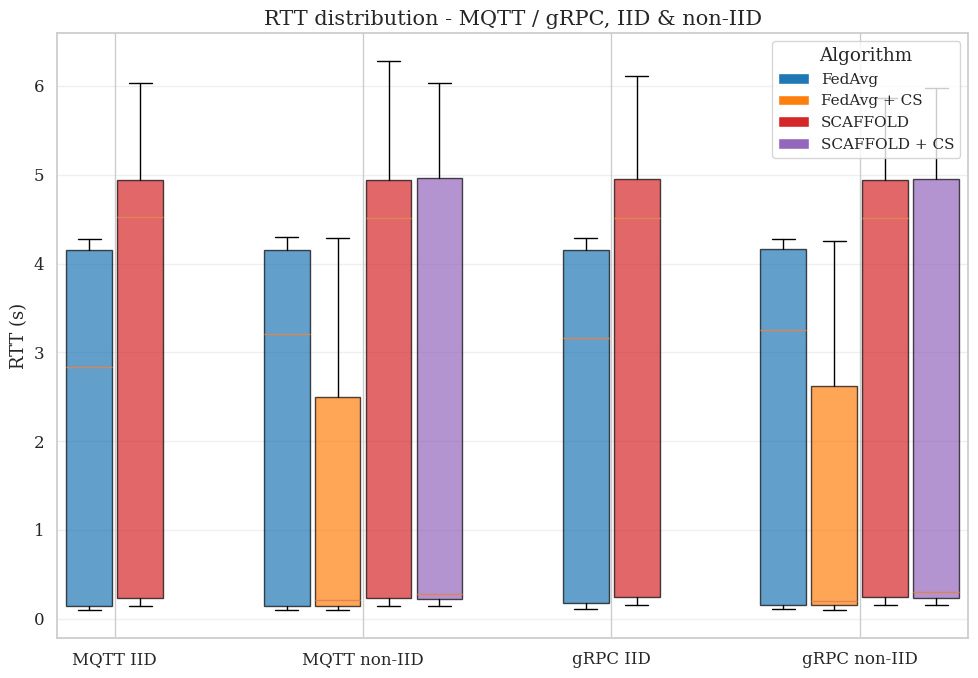

Plot saved ➜ /home/antoniob/FederNet/results/time/async_time_distributions_boxplot.png


In [145]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Box-plot of RTT distributions for MQTT / gRPC, IID & non-IID.
"""
import os, glob, re
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ----------------------------------------------------------------------
# 0. paths & options ----------------------------------------------------
base_path   = "/home/antoniob/FederNet/results/time"          # where logs live
out_dir     = base_path                                       # where figures go
wanted_grp  = {"MQTT IID", "gRPC IID", "MQTT non-IID", "gRPC non-IID"}
trim_ratio  = 0.30                                            # drop first 20 %

algo_colors = {                                               # fixed palette
    "FedAvg"        : "#1f77b4",
    "FedAvg + CS"   : "#ff7f0e",
    "SCAFFOLD"      : "#d62728",
    "SCAFFOLD + CS" : "#9467bd",
}

# ----------------------------------------------------------------------
# 1. helpers ------------------------------------------------------------
def parse_file_info(path):
    """Return (group, algorithm) from filename / directory."""
    fn   = os.path.basename(path)
    dnam = os.path.basename(os.path.dirname(path))

    # protocol ----------------------------------------------------------
    if   "mqtt" in dnam.lower() or "mqtt" in fn.lower():  proto = "MQTT"
    elif "grpc" in dnam.lower() or "grpc" in fn.lower():  proto = "gRPC"
    else:                                                return None        # unknown

    # distribution ------------------------------------------------------
    iid_flags = ("iid", "_iid")
    noniid_flags = ("non-iid", "noniid", "non_iid", "no_iid")
    dstr = "IID" if any(x in dnam.lower() or x in fn.lower() for x in iid_flags)      \
                  and not any(x in dnam.lower() or x in fn.lower() for x in noniid_flags) \
           else "non-IID" if any(x in dnam.lower() or x in fn.lower() for x in noniid_flags) \
           else None
    if dstr is None:
        return None                                                     # unknown

    # algorithm ---------------------------------------------------------
    algo = ("FedAvg"   if re.search(r"fedavg|fed_avg", fn, re.I) else
            "SCAFFOLD" if re.search(r"scaffold",        fn, re.I) else
            None)
    if algo is None: return None

    has_cs = bool(re.search(r"_cs_|_cs$|_cs\.", fn, re.I))
    algo_full = f"{algo} + CS" if has_cs else algo

    return f"{proto} {dstr}", algo_full


def extract_times(path):
    """Return list of RTT floats for one file (empty if none)."""
    vals = []
    with open(path, encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            m = re.search(r"Round\s+\d+,\s*time\s+for\s+.*?\s+is\s+([\d.]+)", line)
            if m:
                vals.append(float(m.group(1)))
    return vals

# ----------------------------------------------------------------------
# 2. scan logs ----------------------------------------------------------
print("Scanning log hierarchy …")
raw = defaultdict(lambda: defaultdict(list))      # {group → {algo → [v,…]}}

for logfile in glob.iglob(os.path.join(base_path, "**/*.log"), recursive=True):
    info = parse_file_info(logfile)
    if info is None:                       # skip unrecognised files
        continue
    group, algo = info
    if group not in wanted_grp:            # skip groups not requested
        continue

    data = extract_times(logfile)
    if not data:
        print(f"[warn] no RTTs in {logfile}")
        continue
    # drop first k samples
    k = int(len(data) * trim_ratio)
    raw[group][algo].extend(data[k:])

# guard
if not raw:
    raise RuntimeError("No usable data found - check base_path and naming rules.")

# ----------------------------------------------------------------------
# 3. build box-plot -----------------------------------------------------
plt.figure(figsize=(10, 7))

positions, box_data, colours = [], [], []
group_centres = {}
box_w, gap = 0.8, 1.5
pos = 1

for grp in sorted(raw):
    algos = sorted(raw[grp])
    start = pos
    for algo in algos:
        positions.append(pos)
        box_data.append(raw[grp][algo])
        colours.append(algo_colors.get(algo, "#000000"))
        pos += box_w
    group_centres[grp] = (start + pos - box_w) / 2
    pos += gap                            # blank space between groups

bp = plt.boxplot(box_data, positions=positions, widths=box_w * 0.9,
                 patch_artist=True, showfliers=True)

for box, c in zip(bp["boxes"], colours):
    box.set(facecolor=c, alpha=0.70)

plt.xticks(list(group_centres.values()), list(group_centres.keys()), fontsize=12)
plt.ylabel("RTT (s)", fontsize=13)
plt.title("RTT distribution - MQTT / gRPC, IID & non-IID", fontsize=15)

handles = [Patch(facecolor=algo_colors[a], label=a) for a in sorted(algo_colors)]
plt.legend(handles=handles, title="Algorithm", loc="upper right", fontsize=11)

plt.grid(axis="y", alpha=0.30)
plt.tight_layout()

png_out = os.path.join(out_dir, "async_time_distributions_boxplot.png")


# plt.yscale("log")  # Use logarithmic scale for better visibility

plt.savefig(png_out, dpi=300)
plt.show()

print(f"Plot saved ➜ {png_out}")


Scanning log hierarchy …


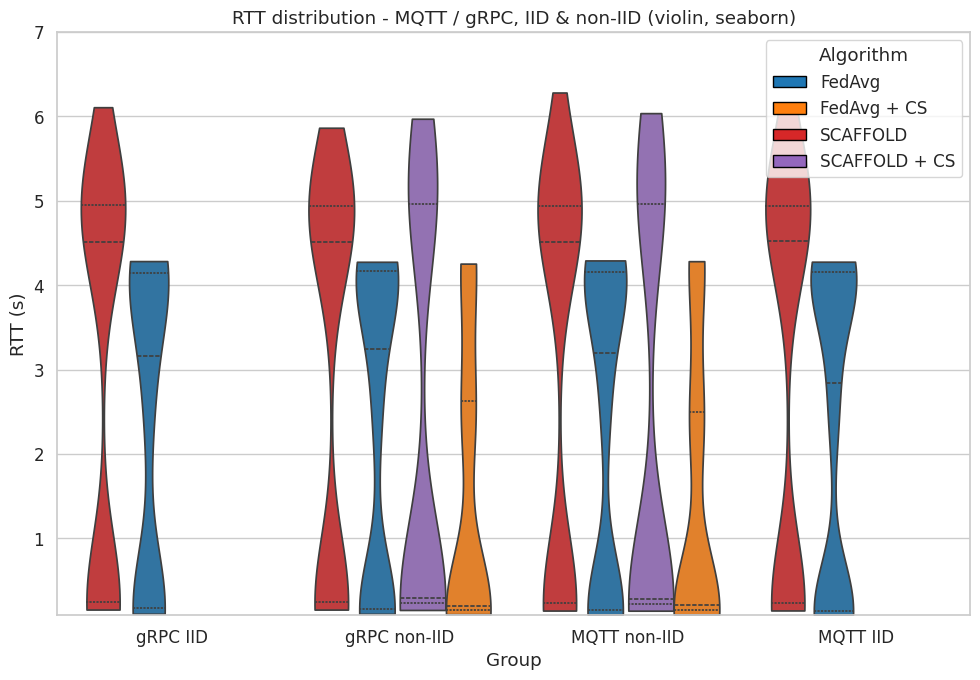

Plot saved ➜ /home/antoniob/FederNet/results/time/async_time_distributions_violinplot.png


In [146]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Violin plot of RTT distributions for MQTT / gRPC, IID & non-IID (seaborn).
"""
import os, glob, re
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ----------------------------------------------------------------------
# 0. paths & options ----------------------------------------------------
base_path   = "/home/antoniob/FederNet/results/time"          # where logs live
out_dir     = base_path                                       # where figures go
wanted_grp  = {"MQTT IID", "gRPC IID", "MQTT non-IID", "gRPC non-IID"}
trim_ratio  = 0.30                                            # drop first 30 %

algo_colors = {                                               # fixed palette
    "FedAvg"        : "#1f77b4",
    "FedAvg + CS"   : "#ff7f0e",
    "SCAFFOLD"      : "#d62728",
    "SCAFFOLD + CS" : "#9467bd",
}

# ----------------------------------------------------------------------
# 1. helpers ------------------------------------------------------------

def parse_file_info(path):
    """Return (group, algorithm) from filename / directory."""
    fn   = os.path.basename(path)
    dnam = os.path.basename(os.path.dirname(path))

    # protocol ----------------------------------------------------------
    if   "mqtt" in dnam.lower() or "mqtt" in fn.lower():  proto = "MQTT"
    elif "grpc" in dnam.lower() or "grpc" in fn.lower():  proto = "gRPC"
    else:                                                return None        # unknown

    # distribution ------------------------------------------------------
    iid_flags = ("iid", "_iid")
    noniid_flags = ("non-iid", "noniid", "non_iid", "no_iid")
    dstr = "IID" if any(x in dnam.lower() or x in fn.lower() for x in iid_flags)      and not any(x in dnam.lower() or x in fn.lower() for x in noniid_flags) else "non-IID" if any(x in dnam.lower() or x in fn.lower() for x in noniid_flags) else None
    if dstr is None:
        return None                                                     # unknown

    # algorithm ---------------------------------------------------------
    algo = ("FedAvg"   if re.search(r"fedavg|fed_avg", fn, re.I) else
            "SCAFFOLD" if re.search(r"scaffold",        fn, re.I) else
            None)
    if algo is None: return None

    has_cs = bool(re.search(r"_cs_|_cs$|_cs\.", fn, re.I))
    algo_full = f"{algo} + CS" if has_cs else algo

    return f"{proto} {dstr}", algo_full


def extract_times(path):
    """Return list of RTT floats for one file (empty if none)."""
    vals = []
    with open(path, encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            m = re.search(r"Round\s+\d+,\s*time\s+for\s+.*?\s+is\s+([\d.]+)", line)
            if m:
                vals.append(float(m.group(1)))
    return vals

# ----------------------------------------------------------------------
# 2. scan logs ----------------------------------------------------------
print("Scanning log hierarchy …")
records = []      # list of dicts for DataFrame

for logfile in glob.iglob(os.path.join(base_path, "**/*.log"), recursive=True):
    info = parse_file_info(logfile)
    if info is None:                       # skip unrecognised files
        continue
    group, algo = info
    if group not in wanted_grp:            # skip groups not requested
        continue

    data = extract_times(logfile)
    if not data:
        print(f"[warn] no RTTs in {logfile}")
        continue
    # drop first k samples
    k = int(len(data) * trim_ratio)
    for v in data[k:]:
        records.append({"Group": group, "Algorithm": algo, "RTT": v})

# guard
if not records:
    raise RuntimeError("No usable data found - check base_path and naming rules.")

df = pd.DataFrame.from_records(records)

# ----------------------------------------------------------------------
# 3. build violin-plot (seaborn) ---------------------------------------
sns.set(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(10, 7))

sns.violinplot(
    data=df,
    x="Group",
    y="RTT",
    hue="Algorithm",
    palette=algo_colors,
    # dodge=True,
    # split=True,
    cut=0,
    # inner_kws=dict(box_width=3, whis_width=1, color=".8")
    inner="quartile"
)

plt.ylabel("RTT (s)")
plt.title("RTT distribution - MQTT / gRPC, IID & non-IID (violin, seaborn)")
# plt.yscale("log")  # Use logarithmic scale for better visibility

plt.ylim(0.09,7)
handles = [Patch(facecolor=algo_colors[a], edgecolor="black", label=a) for a in sorted(algo_colors)]
plt.legend(title="Algorithm", handles=handles, loc="upper right")

plt.tight_layout()

png_out = os.path.join(out_dir, "async_time_distributions_violinplot.png")

# plt.yscale("log")  # Uncomment for logarithmic scale if needed

plt.savefig(png_out, dpi=300)
plt.show()

print(f"Plot saved ➜ {png_out}")

# End of script

Scanning log hierarchy …


/tmp/ipykernel_1499627/1829369112.py:96: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


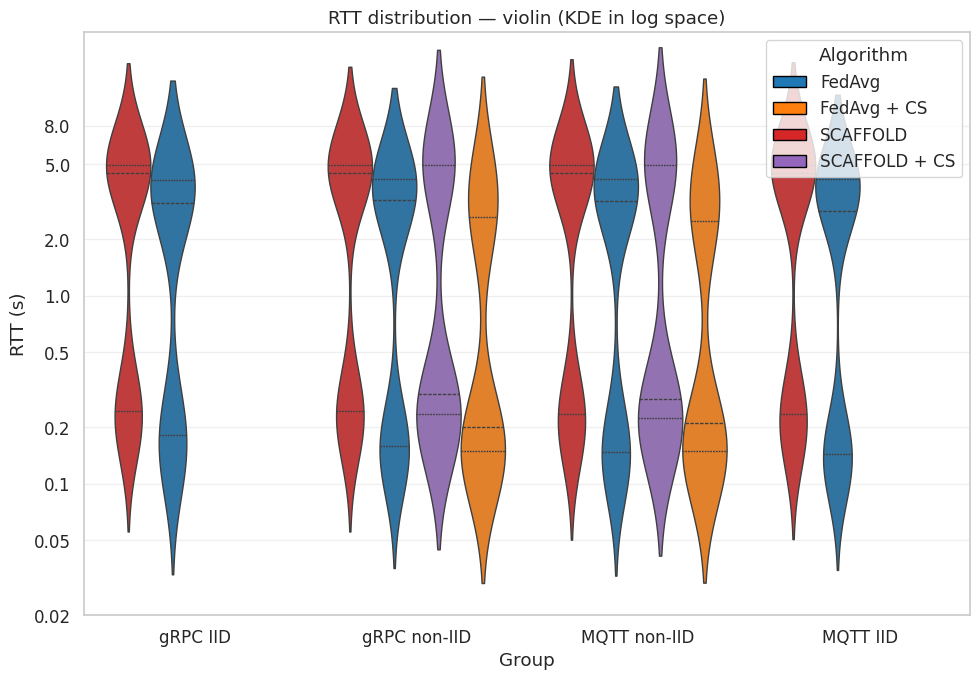

In [147]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Violin plot of RTT distributions (KDE done in log space, shown in seconds).
"""
import os, glob, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ----------------------------------------------------------------------
# 0. paths & options ----------------------------------------------------
base_path   = "/home/antoniob/FederNet/results/time"
wanted_grp  = {"MQTT IID", "gRPC IID", "MQTT non-IID", "gRPC non-IID"}
trim_ratio  = 0.30

algo_colors = {
    "FedAvg"        : "#1f77b4",
    "FedAvg + CS"   : "#ff7f0e",
    "SCAFFOLD"      : "#d62728",
    "SCAFFOLD + CS" : "#9467bd",
}

# ----------------------------------------------------------------------
# 1. helpers ------------------------------------------------------------
def parse_file_info(path):
    fn   = os.path.basename(path)
    dnam = os.path.basename(os.path.dirname(path))
    if   "mqtt" in dnam.lower() or "mqtt" in fn.lower():  proto = "MQTT"
    elif "grpc" in dnam.lower() or "grpc" in fn.lower():  proto = "gRPC"
    else: return None

    iid_flags = ("iid", "_iid")
    noniid_flags = ("non-iid", "noniid", "non_iid", "no_iid")
    dstr = ("IID" if any(x in dnam.lower() or x in fn.lower() for x in iid_flags)
                   and not any(x in dnam.lower() or x in fn.lower() for x in noniid_flags)
            else "non-IID" if any(x in dnam.lower() or x in fn.lower() for x in noniid_flags)
            else None)
    if dstr is None: return None

    algo = ("FedAvg"   if re.search(r"fedavg|fed_avg", fn, re.I) else
            "SCAFFOLD" if re.search(r"scaffold",        fn, re.I) else None)
    if algo is None: return None
    has_cs = bool(re.search(r"_cs_|_cs$|_cs\.", fn, re.I))
    return f"{proto} {dstr}", (f"{algo} + CS" if has_cs else algo)

def extract_times(path):
    vals = []
    with open(path, encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            m = re.search(r"Round\s+\d+,\s*time\s+for\s+.*?\s+is\s+([\d.]+)", line)
            if m:
                v = float(m.group(1))
                if v > 0:
                    vals.append(v)
    return vals

# ----------------------------------------------------------------------
# 2. scan logs ----------------------------------------------------------
print("Scanning log hierarchy …")
records = []
for logfile in glob.iglob(os.path.join(base_path, "**/*.log"), recursive=True):
    info = parse_file_info(logfile)
    if info is None: continue
    group, algo = info
    if group not in wanted_grp: continue

    data = extract_times(logfile)
    if not data:
        print(f"[warn] no RTTs in {logfile}")
        continue

    k = int(len(data) * trim_ratio)
    for v in data[k:]:
        records.append({"Group": group, "Algorithm": algo, "RTT": v})

if not records:
    raise RuntimeError("No usable data found - check base_path and naming rules.")

df = pd.DataFrame.from_records(records)

# --- do KDE in log space -----------------------------------------------------
df["logRTT"] = np.log10(df["RTT"])

# choose display range in seconds (no need for cut to avoid <0)
sec_min, sec_max = 0.1, 8.0
log_min, log_max = np.log10(sec_min), np.log10(sec_max)

# ----------------------------------------------------------------------
# 3. violin (KDE on logRTT, axis labeled in seconds) -------------------
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 7))

ax = sns.violinplot(
    data=df,
    x="Group",
    y="logRTT",              # KDE happens in log space
    hue="Algorithm",
    palette=algo_colors,
    inner="quartile",
    # cut=0,                   # avoid tails beyond min/max in log space
    scale="width",           # comparable widths
    linewidth=1
)

# y-axis: show seconds, but keep spacing uniform (logRTT values)
ticks_sec = np.array([0.02,0.05,0.1, 0.2, 0.5, 1, 2, 5, 8])
ax.set_ylim(0.0001, log_max+0.5)
ax.set_yticks(np.log10(ticks_sec))
ax.set_yticklabels([str(t) for t in ticks_sec])

ax.set_ylabel("RTT (s)")
ax.set_title("RTT distribution — violin (KDE in log space)")
handles = [Patch(facecolor=algo_colors[a], edgecolor="black", label=a) for a in sorted(algo_colors)]
ax.legend(title="Algorithm", handles=handles, loc="upper right")
ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


Scanning log hierarchy …


/tmp/ipykernel_1499627/328381760.py:103: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


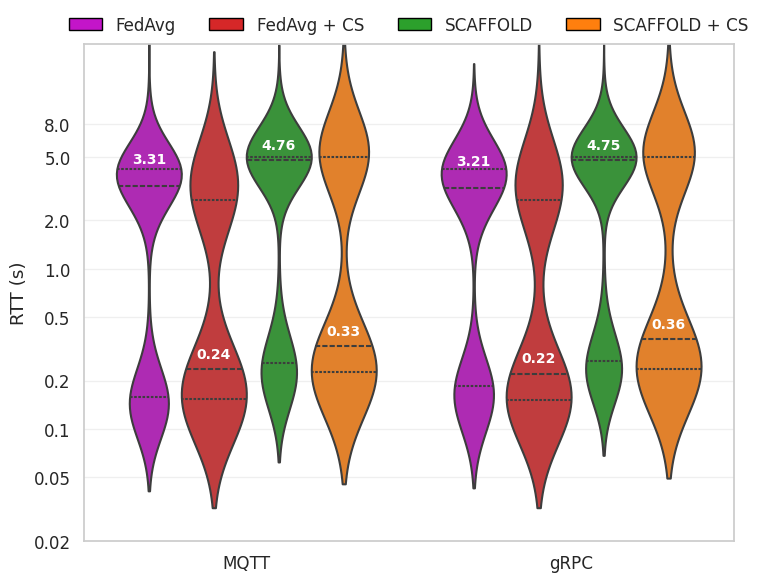

In [148]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Violin plot of RTT distributions (KDE done in log space, shown in seconds).
IID and non-IID are aggregated into a single protocol category (MQTT, gRPC).
"""
import os, glob, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ----------------------------------------------------------------------
# 0. paths & options ----------------------------------------------------
base_path   = "/home/antoniob/FederNet/results/time"
wanted_grp  = {"MQTT IID", "gRPC IID", "MQTT non-IID", "gRPC non-IID"}
trim_ratio  = 0.01

algo_colors = {
    "FedAvg"        : "#c315c9",
    "FedAvg + CS"   : "#d62728",
    "SCAFFOLD"      : "#2ca02c",
    "SCAFFOLD + CS" : "#ff7f0e",
}

# ----------------------------------------------------------------------
# 1. helpers ------------------------------------------------------------
def parse_file_info(path):
    fn   = os.path.basename(path)
    dnam = os.path.basename(os.path.dirname(path))
    if   "mqtt" in dnam.lower() or "mqtt" in fn.lower():  proto = "MQTT"
    elif "grpc" in dnam.lower() or "grpc" in fn.lower():  proto = "gRPC"
    else: return None

    iid_flags = ("iid", "_iid")
    noniid_flags = ("non-iid", "noniid", "non_iid", "no_iid")
    dstr = ("IID" if any(x in dnam.lower() or x in fn.lower() for x in iid_flags)
                   and not any(x in dnam.lower() or x in fn.lower() for x in noniid_flags)
            else "non-IID" if any(x in dnam.lower() or x in fn.lower() for x in noniid_flags)
            else None)
    if dstr is None: return None

    algo = ("FedAvg"   if re.search(r"fedavg|fed_avg", fn, re.I) else
            "SCAFFOLD" if re.search(r"scaffold",        fn, re.I) else None)
    if algo is None: return None
    has_cs = bool(re.search(r"_cs_|_cs$|_cs\.", fn, re.I))
    return f"{proto} {dstr}", (f"{algo} + CS" if has_cs else algo)

def extract_times(path):
    vals = []
    with open(path, encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            m = re.search(r"Round\s+\d+,\s*time\s+for\s+.*?\s+is\s+([\d.]+)", line)
            if m:
                v = float(m.group(1))
                if v > 0:
                    vals.append(v)
    return vals

# ----------------------------------------------------------------------
# 2. scan logs ----------------------------------------------------------
print("Scanning log hierarchy …")
records = []
for logfile in glob.iglob(os.path.join(base_path, "**/*.log"), recursive=True):
    info = parse_file_info(logfile)
    if info is None: continue
    group, algo = info
    if group not in wanted_grp: continue

    data = extract_times(logfile)
    if not data:
        print(f"[warn] no RTTs in {logfile}")
        continue

    k = int(len(data) * trim_ratio)
    for v in data[k:]:
        records.append({"Group": group, "Algorithm": algo, "RTT": v})

if not records:
    raise RuntimeError("No usable data found - check base_path and naming rules.")

df = pd.DataFrame.from_records(records)

# ----------------------------------------------------------------------
# 3. aggregate IID/non-IID into single protocol -------------------------
df["Protocol"] = df["Group"].str.extract(r"^(MQTT|gRPC)")

# --- do KDE in log space ------------------------------------------------
df["logRTT"] = np.log10(df["RTT"])

# choose display range in seconds
sec_min, sec_max = 0.1, 8.0
log_min, log_max = np.log10(sec_min), np.log10(sec_max)

#---------------------------------------------------------------------
# 4. violin plot --------------------------------------------------------
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(8, 6))

hue_order = ["FedAvg", "FedAvg + CS", "SCAFFOLD", "SCAFFOLD + CS"]

ax = sns.violinplot(
    data=df,
    x="Protocol",
    y="logRTT",
    hue="Algorithm",
    order=["MQTT", "gRPC"],
    hue_order=hue_order,
    palette=algo_colors,
    inner="quartile",
    scale="width",
    width=0.8,  # thinner for more space
    linewidth=1.5,
    legend=False
)

# y-axis ticks (log seconds)
ticks_sec = np.array([0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 8])
ax.set_ylim(np.log10(0.1), np.log10(8.0) + 0.5)
ax.set_yticks(np.log10(ticks_sec))
ax.set_yticklabels([str(t) for t in ticks_sec])

ax.set_ylabel("RTT (s)")
ax.set_xlabel("")

# Legend with fixed order
handles = [Patch(facecolor=algo_colors[a], edgecolor="black", label=a) for a in hue_order]
ax.legend(handles=handles, loc="upper right")

# ----------------------------------------------------------------------
# Add median values as text
# ----------------------------------------------------------------------
grouped = df.groupby(["Protocol", "Algorithm"])["RTT"].median().reset_index()

# Map each (Protocol, Algorithm) to its x-position in the plot
# In seaborn's violinplot with hue, positions are offset inside each category
n_hues = len(hue_order)
positions = {}
for i, proto in enumerate(["MQTT", "gRPC"]):
    for j, algo in enumerate(hue_order):
        x_pos = i - 0.4 + (j + 0.5) * (0.8 / n_hues)  # center each hue in its slot
        positions[(proto, algo)] = x_pos

# Function to pick text color based on background
import matplotlib.colors as mcolors
def get_text_color(hex_color):
    r, g, b = mcolors.to_rgb(hex_color)
    brightness = (r*0.299 + g*0.587 + b*0.114)
    return "black" if brightness > 0.6 else "white"

# Add text labels
for _, row in grouped.iterrows():
    proto, algo, median_val = row["Protocol"], row["Algorithm"], row["RTT"]
    x = positions[(proto, algo)]
    y = np.log10(median_val)
    color = get_text_color(algo_colors[algo])
    ax.text(x, y + 0.05 if (y > np.log10(3.4) or y<np.log10(3)) else y+0.12 , f"{median_val:.2f}", ha="center", va="bottom",
            color=color, fontsize=10, fontweight="bold")

ax.grid(True, axis="y", alpha=0.3)


handles = [Patch(facecolor=algo_colors[a], edgecolor="black", label=a) for a in hue_order]
ax.legend(
    handles=handles,
    title="",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.07),
    borderaxespad=0.0,
    frameon=False,
    ncol=4
)



plt.tight_layout()
plt.savefig(os.path.join(base_path, "time_distributions_violinplot_aggregated.pdf"), dpi=300, bbox_inches='tight')
plt.show()


In [149]:
base_path

'/home/antoniob/FederNet/results/time'

Scanning log hierarchy …


/tmp/ipykernel_1499627/4012041248.py:101: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


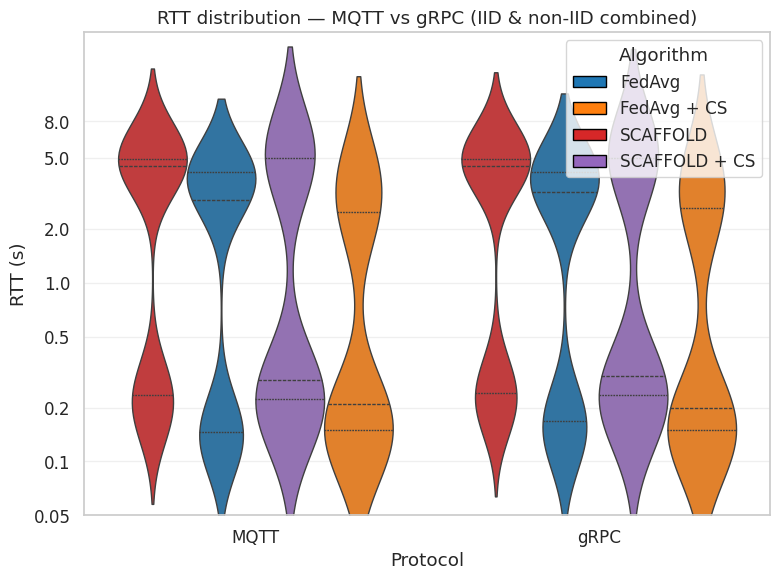

In [150]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Violin plot of RTT distributions (KDE done in log space, shown in seconds).
IID and non-IID are aggregated into a single protocol category (MQTT, gRPC).
"""
import os, glob, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ----------------------------------------------------------------------
# 0. paths & options ----------------------------------------------------
base_path   = "/home/antoniob/FederNet/results/time"
wanted_grp  = {"MQTT IID", "gRPC IID", "MQTT non-IID", "gRPC non-IID"}
trim_ratio  = 0.30

algo_colors = {
    "FedAvg"        : "#1f77b4",
    "FedAvg + CS"   : "#ff7f0e",
    "SCAFFOLD"      : "#d62728",
    "SCAFFOLD + CS" : "#9467bd",
}

# ----------------------------------------------------------------------
# 1. helpers ------------------------------------------------------------
def parse_file_info(path):
    fn   = os.path.basename(path)
    dnam = os.path.basename(os.path.dirname(path))
    if   "mqtt" in dnam.lower() or "mqtt" in fn.lower():  proto = "MQTT"
    elif "grpc" in dnam.lower() or "grpc" in fn.lower():  proto = "gRPC"
    else: return None

    iid_flags = ("iid", "_iid")
    noniid_flags = ("non-iid", "noniid", "non_iid", "no_iid")
    dstr = ("IID" if any(x in dnam.lower() or x in fn.lower() for x in iid_flags)
                   and not any(x in dnam.lower() or x in fn.lower() for x in noniid_flags)
            else "non-IID" if any(x in dnam.lower() or x in fn.lower() for x in noniid_flags)
            else None)
    if dstr is None: return None

    algo = ("FedAvg"   if re.search(r"fedavg|fed_avg", fn, re.I) else
            "SCAFFOLD" if re.search(r"scaffold",        fn, re.I) else None)
    if algo is None: return None
    has_cs = bool(re.search(r"_cs_|_cs$|_cs\.", fn, re.I))
    return f"{proto} {dstr}", (f"{algo} + CS" if has_cs else algo)

def extract_times(path):
    vals = []
    with open(path, encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            m = re.search(r"Round\s+\d+,\s*time\s+for\s+.*?\s+is\s+([\d.]+)", line)
            if m:
                v = float(m.group(1))
                if v > 0:
                    vals.append(v)
    return vals

# ----------------------------------------------------------------------
# 2. scan logs ----------------------------------------------------------
print("Scanning log hierarchy …")
records = []
for logfile in glob.iglob(os.path.join(base_path, "**/*.log"), recursive=True):
    info = parse_file_info(logfile)
    if info is None: continue
    group, algo = info
    if group not in wanted_grp: continue

    data = extract_times(logfile)
    if not data:
        print(f"[warn] no RTTs in {logfile}")
        continue

    k = int(len(data) * trim_ratio)
    for v in data[k:]:
        records.append({"Group": group, "Algorithm": algo, "RTT": v})

if not records:
    raise RuntimeError("No usable data found - check base_path and naming rules.")

df = pd.DataFrame.from_records(records)

# ----------------------------------------------------------------------
# 3. aggregate IID/non-IID into single protocol -------------------------
df["Protocol"] = df["Group"].str.extract(r"^(MQTT|gRPC)")

# --- do KDE in log space ------------------------------------------------
df["logRTT"] = np.log10(df["RTT"])

# choose display range in seconds
sec_min, sec_max = 0.1, 8.0
log_min, log_max = np.log10(sec_min), np.log10(sec_max)

# ----------------------------------------------------------------------
# 4. violin plot --------------------------------------------------------
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(8, 6))

ax = sns.violinplot(
    data=df,
    x="Protocol",
    y="logRTT",              # KDE in log space
    hue="Algorithm",
    order=["MQTT", "gRPC"],  # fixed order
    palette=algo_colors,
    inner="quartile",        # show quartiles & median
    scale="width",
    linewidth=1
)

# y-axis: log scale ticks in seconds
ticks_sec = np.array([0.05, 0.1, 0.2, 0.5, 1, 2, 5, 8])
ax.set_ylim(log_min, log_max + 0.5)
ax.set_yticks(np.log10(ticks_sec))
ax.set_yticklabels([str(t) for t in ticks_sec])

ax.set_ylabel("RTT (s)")
ax.set_xlabel("Protocol")
ax.set_title("RTT distribution — MQTT vs gRPC (IID & non-IID combined)")

# Legend
handles = [Patch(facecolor=algo_colors[a], edgecolor="black", label=a) for a in sorted(algo_colors)]
ax.legend(title="Algorithm", handles=handles, loc="upper right")

ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


Scanning log hierarchy …


/tmp/ipykernel_1499627/2711922603.py:216: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


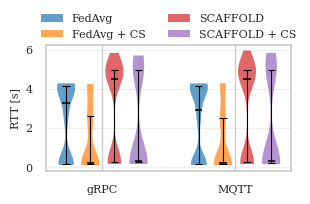

In [151]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Violin plot of RTT distributions (KDE done in log space, shown in seconds).
IID and non-IID are aggregated into a single protocol category (MQTT, gRPC).
"""
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

# ----------------------------------------------------------------------------
# Matplotlib configuration (matching original style) -----------------------
# ----------------------------------------------------------------------------
FONTSIZE = 8
plt.rc("text", usetex=False)
plt.rc("font", family="serif")
plt.rcParams.update({
    "font.size": FONTSIZE,
    "axes.titlesize": FONTSIZE,
    "axes.labelsize": FONTSIZE,
    "xtick.labelsize": FONTSIZE,
    "ytick.labelsize": FONTSIZE,
    "legend.fontsize": FONTSIZE,
    "hatch.linewidth": 1.0,
})

def get_figsize(columnwidth: float, width_frac: float = 0.5,
                height_frac: float = (5.0 ** 0.5 - 1.0) / 1.8) -> list[float]:
    inch_per_pt = 1.0 / 72.27
    fig_w = columnwidth * width_frac * inch_per_pt
    fig_h = fig_w * height_frac
    return [fig_w, fig_h]

def clean_tick_label(x, _):
    if x >= 1:
        return f"1"
    if x == 0.0:
        return f"0"
    return f"{x:.1f}"

# ----------------------------------------------------------------------
# 0. paths & options ----------------------------------------------------
base_path   = "/home/antoniob/FederNet/results/time"
wanted_grp  = {"MQTT IID", "gRPC IID", "MQTT non-IID", "gRPC non-IID"}
trim_ratio  = 0.30

# Updated color palette to match original style exactly
algo_colors = {
    "FedAvg"        : "#1f77b4",
    "FedAvg + CS"   : "#ff7f0e", 
    "SCAFFOLD"      : "#d62728",
    "SCAFFOLD + CS" : "#9467bd",
}

# ----------------------------------------------------------------------
# 1. helpers ------------------------------------------------------------
def parse_file_info(path):
    fn   = os.path.basename(path)
    dnam = os.path.basename(os.path.dirname(path))
    if   "mqtt" in dnam.lower() or "mqtt" in fn.lower():  proto = "MQTT"
    elif "grpc" in dnam.lower() or "grpc" in fn.lower():  proto = "gRPC"
    else: return None

    iid_flags = ("iid", "_iid")
    noniid_flags = ("non-iid", "noniid", "non_iid", "no_iid")
    dstr = ("IID" if any(x in dnam.lower() or x in fn.lower() for x in iid_flags)
                   and not any(x in dnam.lower() or x in fn.lower() for x in noniid_flags)
            else "non-IID" if any(x in dnam.lower() or x in fn.lower() for x in noniid_flags)
            else None)
    if dstr is None: return None

    algo = ("FedAvg"   if re.search(r"fedavg|fed_avg", fn, re.I) else
            "SCAFFOLD" if re.search(r"scaffold",        fn, re.I) else None)
    if algo is None: return None
    has_cs = bool(re.search(r"_cs_|_cs$|_cs\.", fn, re.I))
    return f"{proto} {dstr}", (f"{algo} + CS" if has_cs else algo)

def extract_times(path):
    vals = []
    with open(path, encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            m = re.search(r"Round\s+\d+,\s*time\s+for\s+.*?\s+is\s+([\d.]+)", line)
            if m:
                v = float(m.group(1))
                if v > 0:
                    vals.append(v)
    return vals

# ----------------------------------------------------------------------
# 2. scan logs ----------------------------------------------------------
print("Scanning log hierarchy …")
records = []
for logfile in glob.iglob(os.path.join(base_path, "**/*.log"), recursive=True):
    info = parse_file_info(logfile)
    if info is None: continue
    group, algo = info
    if group not in wanted_grp: continue

    data = extract_times(logfile)
    if not data:
        print(f"[warn] no RTTs in {logfile}")
        continue

    k = int(len(data) * trim_ratio)
    for v in data[k:]:
        records.append({"Group": group, "Algorithm": algo, "RTT": v})

if not records:
    raise RuntimeError("No usable data found - check base_path and naming rules.")

df = pd.DataFrame.from_records(records)

# ----------------------------------------------------------------------
# 3. aggregate IID/non-IID into single protocol -------------------------
df["Protocol"] = df["Group"].str.extract(r"^(MQTT|gRPC)")

# ----------------------------------------------------------------------
# 4. violin plot with original styling ----------------------------------
protocols = df['Protocol'].unique()
# Order algorithms to group base + CS versions together
algorithms = ["FedAvg", "FedAvg + CS", "SCAFFOLD", "SCAFFOLD + CS"]
# Filter to only include algorithms that exist in the data
algorithms = [algo for algo in algorithms if algo in df['Algorithm'].unique()]

# Create figure with exact same styling as original
fig, ax = plt.subplots(figsize=get_figsize(456, height_frac=0.7), layout='constrained')

# Set up positions for violins
positions = []
violin_parts_list = []
position = 0
group_positions = {}

for i, protocol in enumerate(protocols):
    group_start = position
    
    for j, algorithm in enumerate(algorithms):
        # Filter data for this protocol and algorithm
        data_subset = df[(df['Protocol'] == protocol) & (df['Algorithm'] == algorithm)]['RTT'].values
        
        if len(data_subset) > 0:
            # Apply same data trimming as original (1st-99th percentiles)
            p5, p95 = np.percentile(data_subset, [1, 99])
            trimmed_data = data_subset[(data_subset >= p5) & (data_subset <= p95)]
            
            # Create violin plot for this subset with same width as original
            parts = ax.violinplot(
                [trimmed_data],
                positions=[position],
                widths=0.6,  # Exact same width as original
                showmeans=False,
                showmedians=False,
                showextrema=False
            )
            
            # Store parts for later styling
            violin_parts_list.append((parts, algo_colors[algorithm]))
            
            # Calculate quartiles and whiskers from original data (not trimmed)
            q1, median, q3 = np.percentile(data_subset, [25, 50, 75])
            
            # Add quartile lines with exact same styling as original
            ax.hlines(q1, position - 0.12, position + 0.12, color='black', linestyle='-', lw=0.8)
            ax.hlines(median, position - 0.12, position + 0.12, color='black', linestyle='-', lw=1.1)
            ax.hlines(q3, position - 0.12, position + 0.12, color='black', linestyle='-', lw=0.8)
            
            # Add vertical line connecting quartiles
            ax.vlines(position, q1, q3, color='black', linestyle='-', lw=0.8)
            
            positions.append(position)
            position += 0.8  # Same spacing as original
    
    # Store group center position for x-axis labels
    group_end = position - 0.8
    group_positions[protocol] = (group_start + group_end) / 2
    
    # Add space between groups (exact same as original)
    position += 1.2

# Style the violin plots exactly like original
for parts, color in violin_parts_list:
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('none')  # No edge colors like original
        pc.set_alpha(0.7)  # Same alpha as original
        pc.set_linewidth(1.2)

# Set x-axis labels and ticks
ax.set_xticks(list(group_positions.values()))
ax.set_xticklabels(list(group_positions.keys()))

# Add legend for algorithms (same style as original)
legend_elements = [Patch(facecolor=algo_colors[algorithm], 
                         alpha=0.7, 
                         edgecolor='none',  # No edge color like original
                         label=algorithm) 
                   for algorithm in algorithms]

ax.legend(handles=legend_elements,
    title="",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.28),  # Exact same positioning as original
    borderaxespad=0.0,
    frameon=False,  # No frame like original
    ncol=2)  # Same column count as original

# Labels and styling (matching original exactly)
ax.set_xlabel('')
ax.set_ylabel('RTT [s]')
ax.grid(True, alpha=0.3, axis='y')  # Same grid styling as original

# ax.set_ylim(0, 8.5)  # Set y-limits to match original
plt.tight_layout()
# Uncomment to save:
plt.savefig(os.path.join(os.getcwd(), "time_distributions_violinplot_protocols.pdf"), dpi=300, bbox_inches='tight')
plt.show()

Scanning log hierarchy …


/tmp/ipykernel_1499627/2753434905.py:218: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


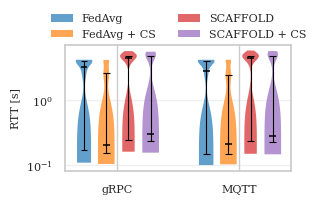

In [152]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Violin plot of RTT distributions (KDE done in log space, shown in seconds).
IID and non-IID are aggregated into a single protocol category (MQTT, gRPC).
"""
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

# ----------------------------------------------------------------------------
# Matplotlib configuration (matching original style) -----------------------
# ----------------------------------------------------------------------------
FONTSIZE = 8
plt.rc("text", usetex=False)
plt.rc("font", family="serif")
plt.rcParams.update({
    "font.size": FONTSIZE,
    "axes.titlesize": FONTSIZE,
    "axes.labelsize": FONTSIZE,
    "xtick.labelsize": FONTSIZE,
    "ytick.labelsize": FONTSIZE,
    "legend.fontsize": FONTSIZE,
    "hatch.linewidth": 1.0,
})

def get_figsize(columnwidth: float, width_frac: float = 0.5,
                height_frac: float = (5.0 ** 0.5 - 1.0) / 1.8) -> list[float]:
    inch_per_pt = 1.0 / 72.27
    fig_w = columnwidth * width_frac * inch_per_pt
    fig_h = fig_w * height_frac
    return [fig_w, fig_h]

def clean_tick_label(x, _):
    if x >= 1:
        return f"1"
    if x == 0.0:
        return f"0"
    return f"{x:.1f}"

# ----------------------------------------------------------------------
# 0. paths & options ----------------------------------------------------
base_path   = "/home/antoniob/FederNet/results/time"
wanted_grp  = {"MQTT IID", "gRPC IID", "MQTT non-IID", "gRPC non-IID"}
trim_ratio  = 0.30

# Updated color palette to match original style exactly
algo_colors = {
    "FedAvg"        : "#1f77b4",
    "FedAvg + CS"   : "#ff7f0e", 
    "SCAFFOLD"      : "#d62728",
    "SCAFFOLD + CS" : "#9467bd",
}

# ----------------------------------------------------------------------
# 1. helpers ------------------------------------------------------------
def parse_file_info(path):
    fn   = os.path.basename(path)
    dnam = os.path.basename(os.path.dirname(path))
    if   "mqtt" in dnam.lower() or "mqtt" in fn.lower():  proto = "MQTT"
    elif "grpc" in dnam.lower() or "grpc" in fn.lower():  proto = "gRPC"
    else: return None

    iid_flags = ("iid", "_iid")
    noniid_flags = ("non-iid", "noniid", "non_iid", "no_iid")
    dstr = ("IID" if any(x in dnam.lower() or x in fn.lower() for x in iid_flags)
                   and not any(x in dnam.lower() or x in fn.lower() for x in noniid_flags)
            else "non-IID" if any(x in dnam.lower() or x in fn.lower() for x in noniid_flags)
            else None)
    if dstr is None: return None

    algo = ("FedAvg"   if re.search(r"fedavg|fed_avg", fn, re.I) else
            "SCAFFOLD" if re.search(r"scaffold",        fn, re.I) else None)
    if algo is None: return None
    has_cs = bool(re.search(r"_cs_|_cs$|_cs\.", fn, re.I))
    return f"{proto} {dstr}", (f"{algo} + CS" if has_cs else algo)

def extract_times(path):
    vals = []
    with open(path, encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            m = re.search(r"Round\s+\d+,\s*time\s+for\s+.*?\s+is\s+([\d.]+)", line)
            if m:
                v = float(m.group(1))
                if v > 0:
                    vals.append(v)
    return vals

# ----------------------------------------------------------------------
# 2. scan logs ----------------------------------------------------------
print("Scanning log hierarchy …")
records = []
for logfile in glob.iglob(os.path.join(base_path, "**/*.log"), recursive=True):
    info = parse_file_info(logfile)
    if info is None: continue
    group, algo = info
    if group not in wanted_grp: continue

    data = extract_times(logfile)
    if not data:
        print(f"[warn] no RTTs in {logfile}")
        continue

    k = int(len(data) * trim_ratio)
    for v in data[k:]:
        records.append({"Group": group, "Algorithm": algo, "RTT": v})

if not records:
    raise RuntimeError("No usable data found - check base_path and naming rules.")

df = pd.DataFrame.from_records(records)

# ----------------------------------------------------------------------
# 3. aggregate IID/non-IID into single protocol -------------------------
df["Protocol"] = df["Group"].str.extract(r"^(MQTT|gRPC)")

# ----------------------------------------------------------------------
# 4. violin plot with original styling ----------------------------------
protocols = df['Protocol'].unique()
# Order algorithms to group base + CS versions together
algorithms = ["FedAvg", "FedAvg + CS", "SCAFFOLD", "SCAFFOLD + CS"]
# Filter to only include algorithms that exist in the data
algorithms = [algo for algo in algorithms if algo in df['Algorithm'].unique()]

# Create figure with exact same styling as original
fig, ax = plt.subplots(figsize=get_figsize(456, height_frac=0.7), layout='constrained')

# Set up positions for violins
positions = []
violin_parts_list = []
position = 0
group_positions = {}

for i, protocol in enumerate(protocols):
    group_start = position
    
    for j, algorithm in enumerate(algorithms):
        # Filter data for this protocol and algorithm
        data_subset = df[(df['Protocol'] == protocol) & (df['Algorithm'] == algorithm)]['RTT'].values
        
        if len(data_subset) > 0:
            # Apply same data trimming as original (1st-99th percentiles)
            p5, p95 = np.percentile(data_subset, [1, 99])
            trimmed_data = data_subset[(data_subset >= p5) & (data_subset <= p95)]
            
            # Create violin plot for this subset with same width as original
            parts = ax.violinplot(
                [trimmed_data],
                positions=[position],
                widths=0.6,  # Exact same width as original
                showmeans=False,
                showmedians=False,
                showextrema=False
            )
            
            # Store parts for later styling
            violin_parts_list.append((parts, algo_colors[algorithm]))
            
            # Calculate quartiles and whiskers from original data (not trimmed)
            q1, median, q3 = np.percentile(data_subset, [25, 50, 75])
            
            # Add quartile lines with exact same styling as original
            ax.hlines(q1, position - 0.12, position + 0.12, color='black', linestyle='-', lw=0.8)
            ax.hlines(median, position - 0.12, position + 0.12, color='black', linestyle='-', lw=1.1)
            ax.hlines(q3, position - 0.12, position + 0.12, color='black', linestyle='-', lw=0.8)
            
            # Add vertical line connecting quartiles
            ax.vlines(position, q1, q3, color='black', linestyle='-', lw=0.8)
            
            positions.append(position)
            position += 0.8  # Same spacing as original
    
    # Store group center position for x-axis labels
    group_end = position - 0.8
    group_positions[protocol] = (group_start + group_end) / 2
    
    # Add space between groups (exact same as original)
    position += 1.2

# Style the violin plots exactly like original
for parts, color in violin_parts_list:
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('none')  # No edge colors like original
        pc.set_alpha(0.7)  # Same alpha as original
        pc.set_linewidth(1.2)

# Set x-axis labels and ticks
ax.set_xticks(list(group_positions.values()))
ax.set_xticklabels(list(group_positions.keys()))

# Add legend for algorithms (same style as original)
legend_elements = [Patch(facecolor=algo_colors[algorithm], 
                         alpha=0.7, 
                         edgecolor='none',  # No edge color like original
                         label=algorithm) 
                   for algorithm in algorithms]

ax.legend(handles=legend_elements,
    title="",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.28),  # Exact same positioning as original
    borderaxespad=0.0,
    frameon=False,  # No frame like original
    ncol=2)  # Same column count as original

# Labels and styling (matching original exactly)
ax.set_xlabel('')
ax.set_ylabel('RTT [s]')
ax.grid(True, alpha=0.3, axis='y')  # Same grid styling as original

ax.set_yscale('log')

# ax.set_ylim(0, 8.5)  # Set y-limits to match original
plt.tight_layout()

# Uncomment to save:
plt.savefig(os.path.join(os.getcwd() , "time_distributions_violinplot_protocols_log.pdf"), dpi=300, bbox_inches='tight')
plt.show()

Scanning log hierarchy …
Saved long-format samples ➜ /home/antoniob/FederNet/results/time/rtt_long_samples.csv
Saved summary quantiles ➜ /home/antoniob/FederNet/results/time/rtt_summary_quantiles.csv


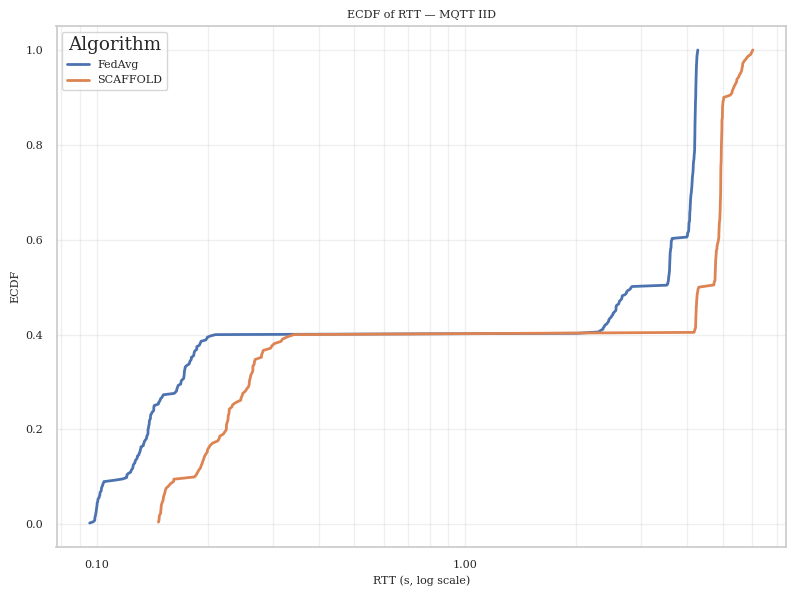

ECDF saved ➜ /home/antoniob/FederNet/results/time/rtt_ecdf_MQTT_IID.png


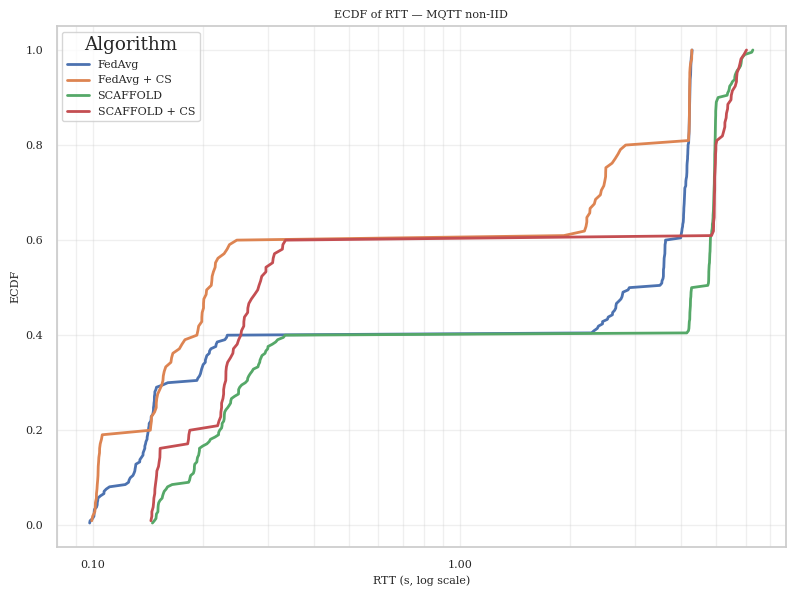

ECDF saved ➜ /home/antoniob/FederNet/results/time/rtt_ecdf_MQTT_non-IID.png


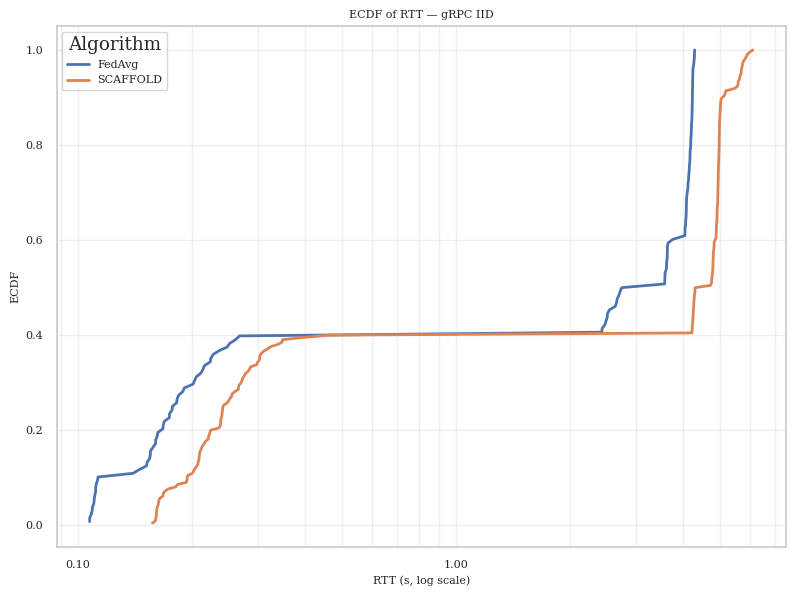

ECDF saved ➜ /home/antoniob/FederNet/results/time/rtt_ecdf_gRPC_IID.png


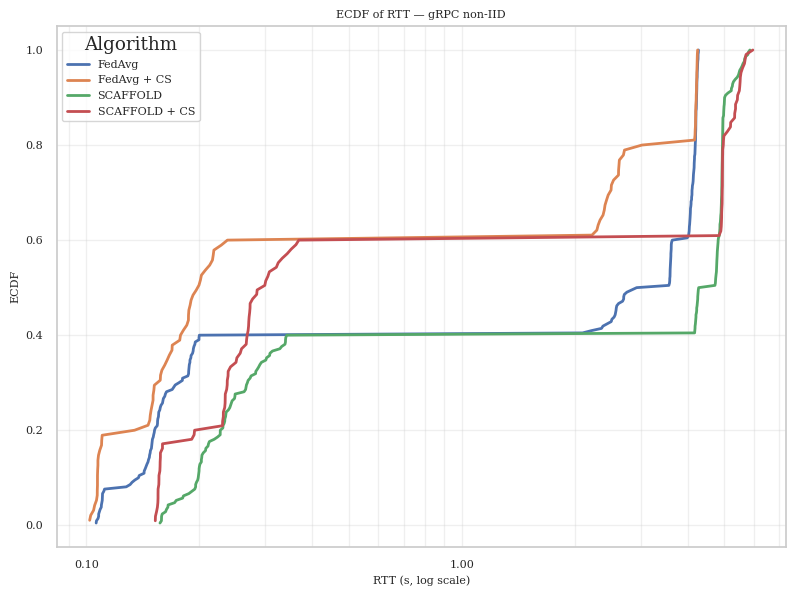

ECDF saved ➜ /home/antoniob/FederNet/results/time/rtt_ecdf_gRPC_non-IID.png


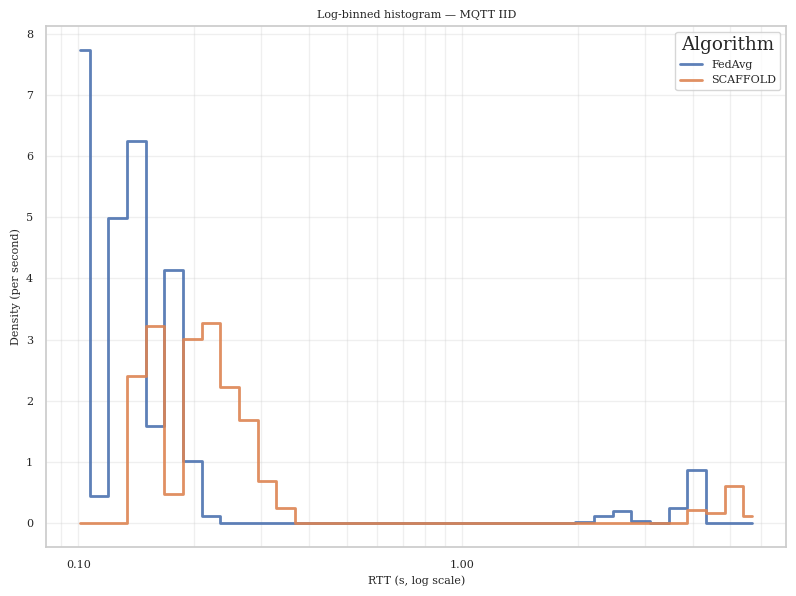

Histogram saved ➜ /home/antoniob/FederNet/results/time/rtt_hist_logbins_MQTT_IID.png


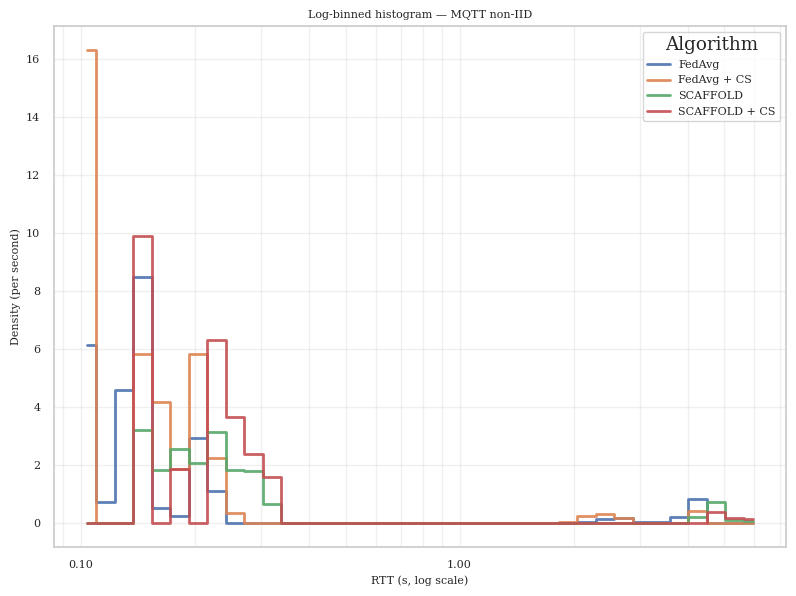

Histogram saved ➜ /home/antoniob/FederNet/results/time/rtt_hist_logbins_MQTT_non-IID.png


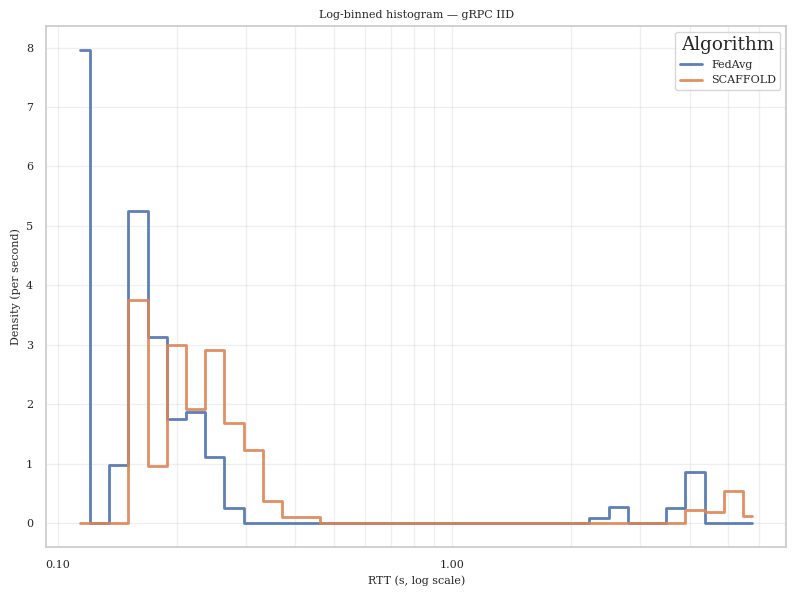

Histogram saved ➜ /home/antoniob/FederNet/results/time/rtt_hist_logbins_gRPC_IID.png


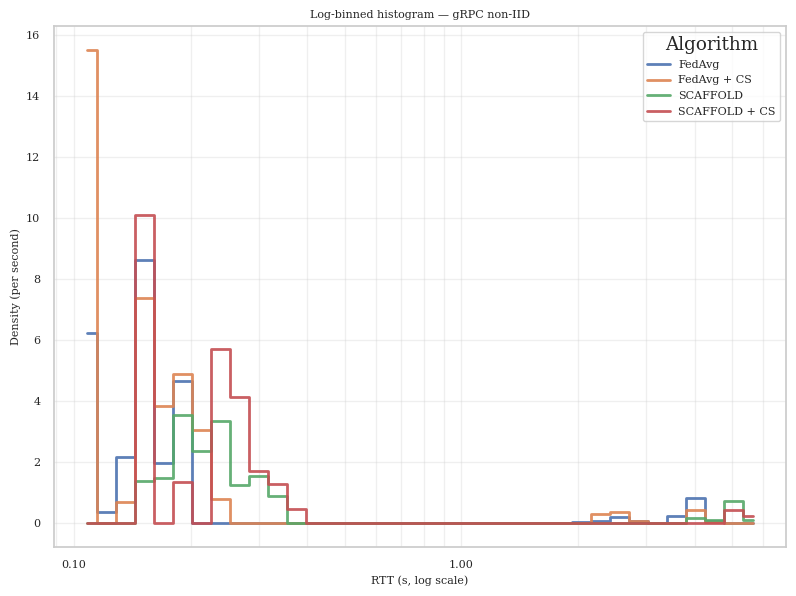

Histogram saved ➜ /home/antoniob/FederNet/results/time/rtt_hist_logbins_gRPC_non-IID.png


/tmp/ipykernel_1499627/3142442504.py:202: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(sec_labels)


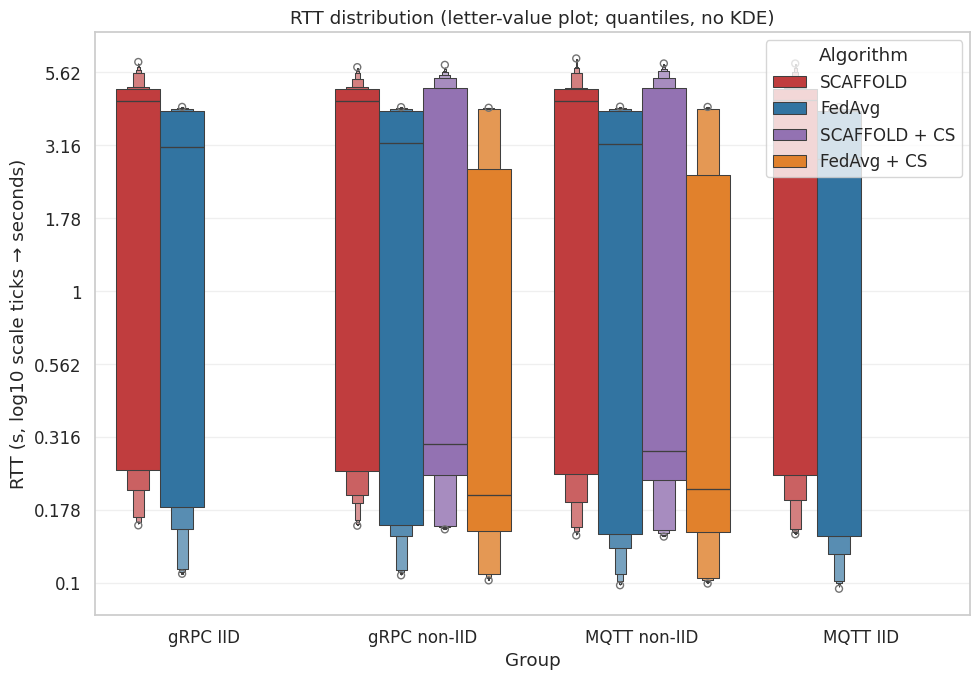

Boxenplot saved ➜ /home/antoniob/FederNet/results/time/rtt_boxen_logdata.png


In [153]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Distribution plots from raw RTT samples (no KDE):
- ECDFs (log-x)
- Log-binned step histograms
- Optional: quantile-based boxenplot (not KDE)
Also exports long-format CSV and summary quantiles CSV.
"""
import os, glob, re
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogLocator
# optional (for boxenplot only — quantiles, not KDE)
import seaborn as sns

# -------- paths & options ----------------------------------------------------
base_path   = "/home/antoniob/FederNet/results/time"
out_dir     = base_path
wanted_grp  = {"MQTT IID", "gRPC IID", "MQTT non-IID", "gRPC non-IID"}
trim_ratio  = 0.30  # drop first 30% samples per file

algo_colors = {
    "FedAvg"        : "#1f77b4",
    "FedAvg + CS"   : "#ff7f0e",
    "SCAFFOLD"      : "#d62728",
    "SCAFFOLD + CS" : "#9467bd",
}

# -------- helpers ------------------------------------------------------------
def parse_file_info(path):
    """Return (group, algorithm) from filename / directory, or None to skip."""
    fn   = os.path.basename(path)
    dnam = os.path.basename(os.path.dirname(path))

    # protocol
    if   "mqtt" in dnam.lower() or "mqtt" in fn.lower():  proto = "MQTT"
    elif "grpc" in dnam.lower() or "grpc" in fn.lower():  proto = "gRPC"
    else:                                                return None

    # distribution
    iid_flags = ("iid", "_iid")
    noniid_flags = ("non-iid", "noniid", "non_iid", "no_iid")
    has_iid = any(x in dnam.lower() or x in fn.lower() for x in iid_flags)
    has_non = any(x in dnam.lower() or x in fn.lower() for x in noniid_flags)
    if has_iid and not has_non:
        dstr = "IID"
    elif has_non:
        dstr = "non-IID"
    else:
        return None

    # algorithm (+ CS)
    algo = ("FedAvg"   if re.search(r"fedavg|fed_avg", fn, re.I) else
            "SCAFFOLD" if re.search(r"scaffold",        fn, re.I) else
            None)
    if algo is None: return None
    has_cs = bool(re.search(r"_cs_|_cs$|_cs\.", fn, re.I))
    algo_full = f"{algo} + CS" if has_cs else algo

    return f"{proto} {dstr}", algo_full

def extract_times(path):
    """Return list of RTT floats for one file (empty if none)."""
    vals = []
    with open(path, encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            m = re.search(r"Round\s+\d+,\s*time\s+for\s+.*?\s+is\s+([\d.]+)", line)
            if m:
                v = float(m.group(1))
                if v > 0:
                    vals.append(v)
    return vals

# -------- scan logs → long tidy DataFrame -----------------------------------
print("Scanning log hierarchy …")
records = []  # list of {Group, Algorithm, RTT}

for logfile in glob.iglob(os.path.join(base_path, "**/*.log"), recursive=True):
    info = parse_file_info(logfile)
    if info is None:
        continue
    group, algo = info
    if group not in wanted_grp:
        continue

    data = extract_times(logfile)
    if not data:
        print(f"[warn] no RTTs in {logfile}")
        continue

    # per-file warmup trimming
    k = int(len(data) * trim_ratio)
    for v in data[k:]:
        records.append({"Group": group, "Algorithm": algo, "RTT": v})

if not records:
    raise RuntimeError("No usable data found - check base_path and naming rules.")

df = pd.DataFrame.from_records(records)
df["log10_RTT"] = np.log10(df["RTT"].values)

# -------- export data --------------------------------------------------------
long_csv = os.path.join(out_dir, "rtt_long_samples.csv")
df.to_csv(long_csv, index=False)
print(f"Saved long-format samples ➜ {long_csv}")

# summary quantiles (pure data, no KDE)
qs = [0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99]
summary = (
    df.groupby(["Group","Algorithm"])["RTT"]
      .agg(**{
          "count":"count","mean":"mean","std":"std","min":"min","max":"max",
          **{f"q{int(q*100)}": lambda s, q=q: s.quantile(q) for q in qs}
      })
      .reset_index()
)
summary_csv = os.path.join(out_dir, "rtt_summary_quantiles.csv")
summary.to_csv(summary_csv, index=False)
print(f"Saved summary quantiles ➜ {summary_csv}")

# -------- plotting: ECDFs (log-x, no KDE) -----------------------------------
def plot_ecdf_per_group(df, out_dir):
    for grp, sub in df.groupby("Group"):
        plt.figure(figsize=(8,6))
        for algo, s in sub.groupby("Algorithm"):
            x = np.sort(s["RTT"].values)
            y = np.arange(1, len(x)+1) / len(x)
            plt.plot(x, y, label=algo, linewidth=2)
        plt.xscale("log")
        plt.gca().xaxis.set_major_locator(LogLocator(base=10))
        plt.gca().xaxis.set_major_formatter(ScalarFormatter())
        plt.xlabel("RTT (s, log scale)")
        plt.ylabel("ECDF")
        plt.title(f"ECDF of RTT — {grp}")
        plt.grid(True, which="both", axis="both", alpha=0.3)
        plt.legend(title="Algorithm")
        plt.tight_layout()
        fn = os.path.join(out_dir, f"rtt_ecdf_{grp.replace(' ','_')}.png")
        plt.savefig(fn, dpi=300)
        plt.show()
        print(f"ECDF saved ➜ {fn}")

plot_ecdf_per_group(df, out_dir)

# -------- plotting: log-binned step histograms (no KDE) ---------------------
def plot_hist_per_group(df, out_dir, bins_per_decade=20):
    for grp, sub in df.groupby("Group"):
        plt.figure(figsize=(8,6))
        # global min/max > 0 for bins
        vmin = sub["RTT"].min()
        vmax = sub["RTT"].max()
        # safety
        vmin = max(vmin, 1e-6)
        # build log-spaced bins with ~constant resolution per decade
        n_dec = np.log10(vmax) - np.log10(vmin)
        nbins = max(int(np.ceil(n_dec * bins_per_decade)), 10)
        bins = np.logspace(np.log10(vmin), np.log10(vmax), nbins+1)

        for algo, s in sub.groupby("Algorithm"):
            counts, edges = np.histogram(s["RTT"].values, bins=bins, density=True)
            centers = np.sqrt(edges[1:] * edges[:-1])  # geometric centers
            plt.step(centers, counts, where="mid", linewidth=2,
                     label=algo, alpha=0.9)

        plt.xscale("log")
        plt.gca().xaxis.set_major_locator(LogLocator(base=10))
        plt.gca().xaxis.set_major_formatter(ScalarFormatter())
        plt.xlabel("RTT (s, log scale)")
        plt.ylabel("Density (per second)")
        plt.title(f"Log-binned histogram — {grp}")
        plt.grid(True, which="both", axis="both", alpha=0.3)
        plt.legend(title="Algorithm")
        plt.tight_layout()
        fn = os.path.join(out_dir, f"rtt_hist_logbins_{grp.replace(' ','_')}.png")
        plt.savefig(fn, dpi=300)
        plt.show()
        print(f"Histogram saved ➜ {fn}")

plot_hist_per_group(df, out_dir)

# -------- optional: boxenplot (quantile-based, not KDE) ---------------------
# Works either with y=RTT + yscale('log') OR with y=log10_RTT and custom ticks.
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10,7))
ax = sns.boxenplot(
    data=df,
    x="Group",
    y="log10_RTT",          # plot on log-data to avoid boundary artefacts
    hue="Algorithm",
    palette=algo_colors,
    dodge=True,
    k_depth="proportion",
    showfliers=True
)

# convert y ticks back to seconds labels
ticks = ax.get_yticks()
sec_labels = [f"{10**t:.3g}" for t in ticks]
ax.set_yticklabels(sec_labels)
ax.set_ylabel("RTT (s, log10 scale ticks → seconds)")
ax.set_title("RTT distribution (letter-value plot; quantiles, no KDE)")
ax.grid(True, axis="y", alpha=0.3)
ax.legend(title="Algorithm", loc="upper right")
plt.tight_layout()
fn = os.path.join(out_dir, "rtt_boxen_logdata.png")
plt.savefig(fn, dpi=300)
plt.show()
print(f"Boxenplot saved ➜ {fn}")


Starting analysis of log files...
Found 12 log files:
  - /home/antoniob/FederNet/results/time_async/grpc_iid/grpc_iid_ASOFed_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time_async/grpc_iid/grpc_iid_unweighted_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time_async/grpc_iid/grpc_iid_fedAsync_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time_async/grpc_iid/grpc_iid_asyncFedED_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time_async/mqtt_no_iid/mqtt_noniid_asyncFedED_NOCS_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time_async/mqtt_no_iid/mqtt_noniid_unweighted_NOCS_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time_async/mqtt_no_iid/mqtt_noniid_fedAsync_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time_async/mqtt_no_iid/mqtt_noniid_ASOFed_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time_async/mqtt_iid/mqtt_iid_unweighted_ps_fed_opt0.log
  - /home/antoniob/FederNet/results/time_async/mqtt_iid/mqtt_iid_fedAsync_ps_fed_opt0.log
  - /h

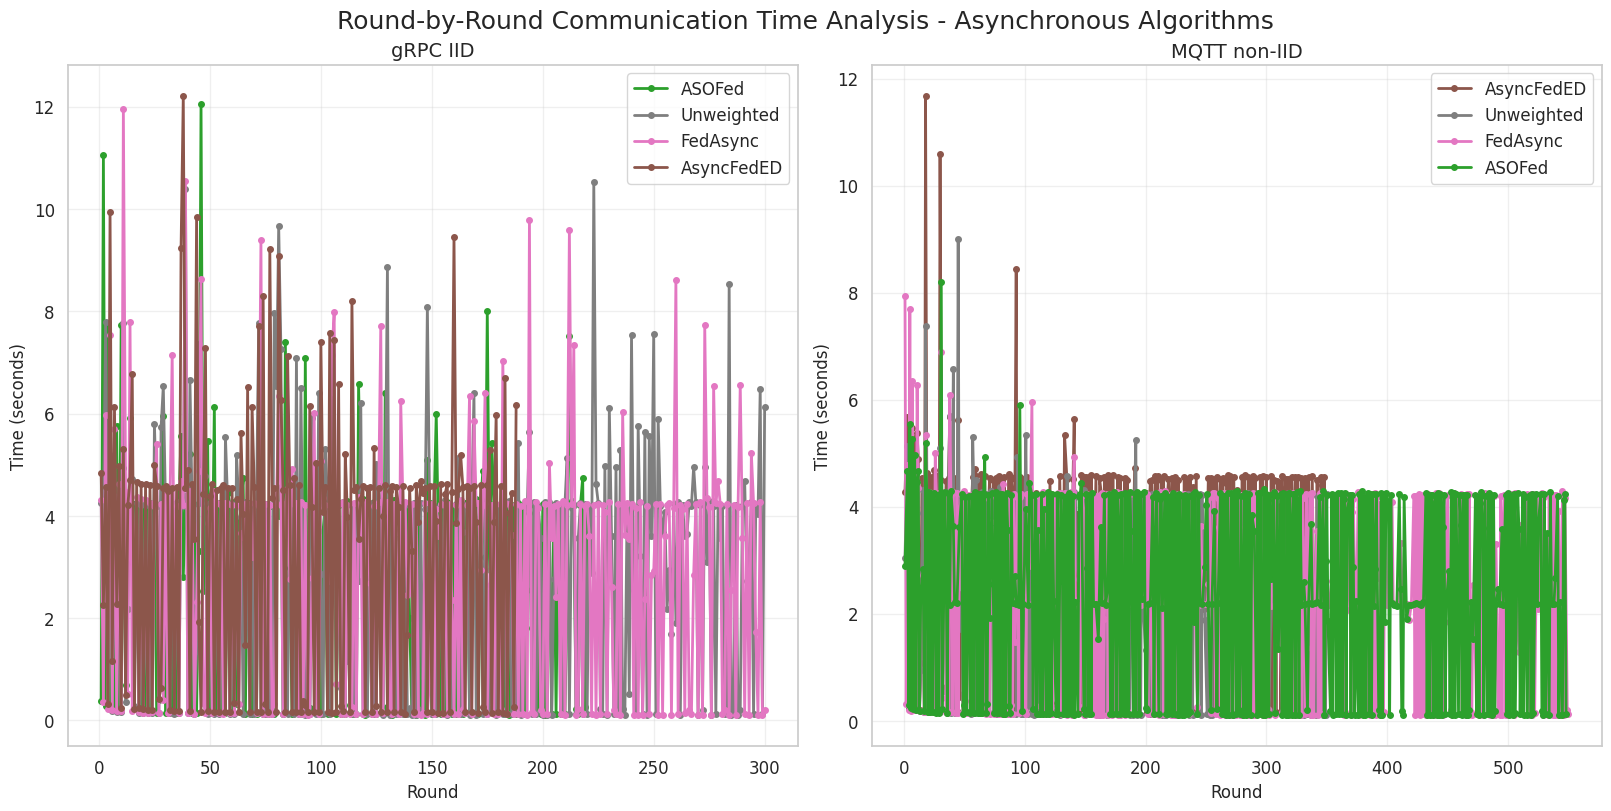

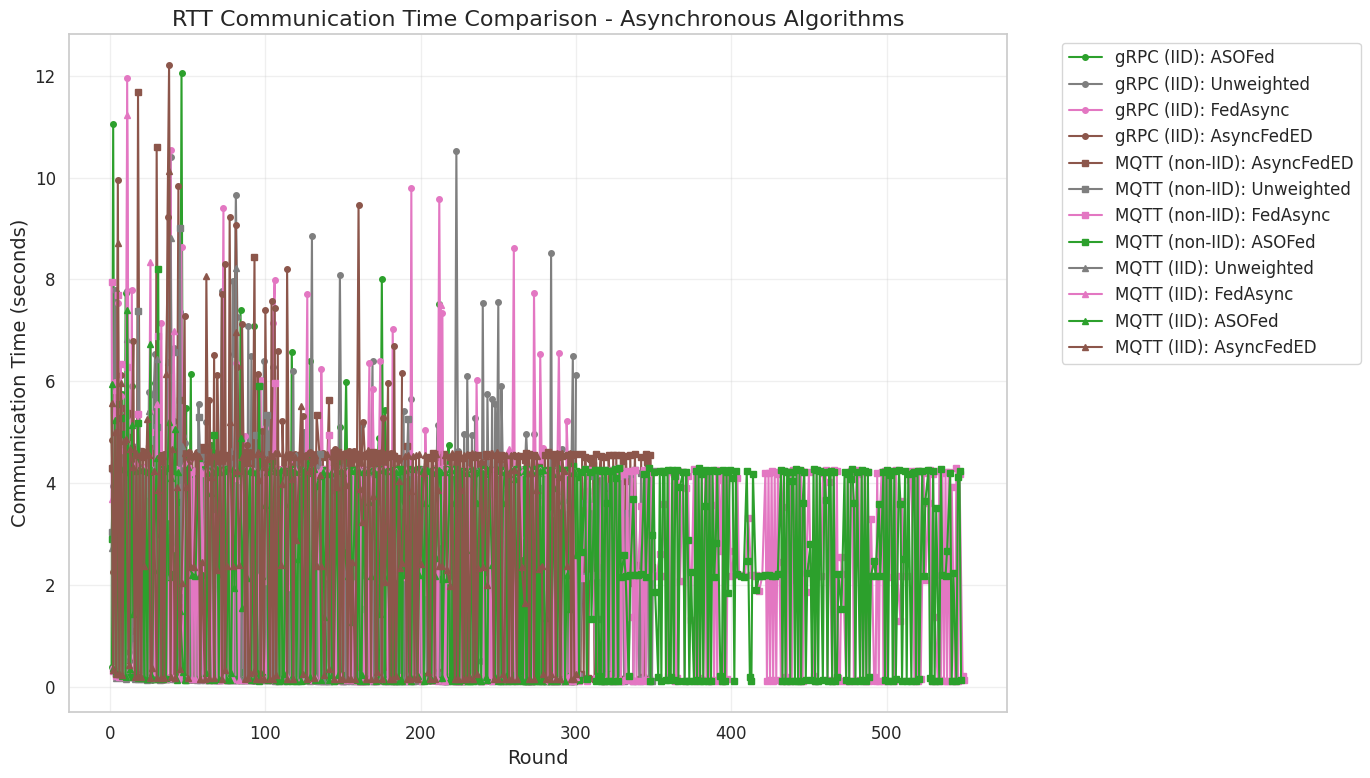

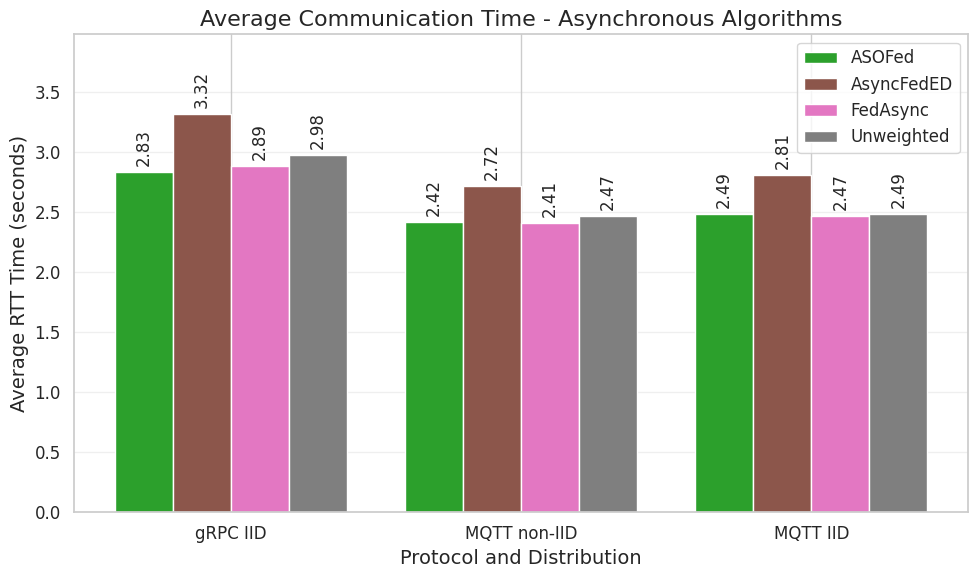

In [154]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import glob
import os
import numpy as np

plt.rcParams.update({
    "font.size": 14,        # base font
    "axes.titlesize": 16,   # subplot / figure titles
    "axes.labelsize": 14,   # x- and y-labels
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

# Updated base path to include both directories
base_path = "/home/antoniob/FederNet/results/time_async"


def extract_round_times(log_file):
    """Extract timing data for each round from a log file"""
    round_times = defaultdict(list)
    try:
        with open(log_file, 'r') as file:
            for line in file:
                match = re.search(r'Round\s+(\d+),\s*time\s+for\s+(.*?)\s+is\s+([\d.]+)', line)
                if match:
                    round_num = int(match.group(1))
                    time_value = float(match.group(3))
                    round_times[round_num].append(time_value)
    except FileNotFoundError:
        print(f"Warning: {log_file} not found")
    except Exception as e:
        print(f"Error reading {log_file}: {e}")
    
    # Calculate average for each round
    round_avg = {}
    for round_num, times in round_times.items():
        if times:
            round_avg[round_num] = sum(times) / len(times)
    
    return round_avg

# Updated function to extract algorithm details from async filenames
def parse_file_info(filename):
    """Parse filename to extract protocol, algorithm, and distribution details"""
    basename = os.path.basename(filename)
    dirname = os.path.basename(os.path.dirname(filename))
    
    # Debug print to help troubleshoot
    print(f"Processing file: {basename} in directory: {dirname}")
    
    # Extract protocol from directory name first, then filename
    protocol = "unknown"
    if "mqtt" in dirname.lower():
        protocol = "MQTT"
    elif "grpc" in dirname.lower():
        protocol = "gRPC"
    elif "mqtt" in basename.lower():
        protocol = "MQTT"
    elif "grpc" in basename.lower():
        protocol = "gRPC"
    
    # Extract distribution from directory name first, then filename
    distribution = "unknown"
    if "iid" in dirname.lower() and "no_iid" not in dirname.lower() and "noniid" not in dirname.lower():
        distribution = "IID"
    elif "no_iid" in dirname.lower() or "noniid" in dirname.lower():
        distribution = "non-IID"
    elif "_iid" in basename.lower() and "noniid" not in basename.lower() and "non_iid" not in basename.lower():
        distribution = "IID"
    elif "noniid" in basename.lower() or "non_iid" in basename.lower() or "no_iid" in basename.lower():
        distribution = "non-IID"
    
    # Extract algorithm - match new asynchronous algorithms
    algorithm = "unknown"
    # Check for standard algorithms first
    if re.search(r'fedavg|fed_avg', basename.lower()):
        algorithm = "FedAvg"
    elif re.search(r'scaffold', basename.lower()):
        algorithm = "SCAFFOLD"
    # Check for new async algorithms
    elif "asofed" in basename.lower():
        algorithm = "ASOFed"
    elif "asyncfeded" in basename.lower():
        algorithm = "AsyncFedED"  
    elif "fedasync" in basename.lower():
        algorithm = "FedAsync"
    elif "unweighted" in basename.lower():
        algorithm = "Unweighted"
        
    # Determine client selection status - more comprehensive checks
    has_cs = False
    if "_cs_" in basename.lower() or basename.lower().endswith("_cs") or "_cs." in basename.lower():
        has_cs = True
    elif "nocs" in basename.lower():
        has_cs = False
    
    # Create identifier for the algorithm
    algorithm_id = f"{algorithm}"
    if has_cs:
        algorithm_id += " + CS"
        
    group = f"{protocol} {distribution}"
    
    # Debug output for troubleshooting
    print(f"  → Protocol: {protocol}, Distribution: {distribution}, Algorithm: {algorithm_id}")
    
    return {
        "group": group,
        "algorithm": algorithm_id,
        "protocol": protocol,
        "distribution": distribution,
        "has_cs": has_cs,
        "base_algo": algorithm
    }

# Function to analyze all available logs
def analyze_logs():
    # Get all log files recursively, with more detailed debug output
    log_files = glob.glob(os.path.join(base_path, "**/*.log"), recursive=True)
    print(f"Found {len(log_files)} log files:")
    for f in log_files:
        print(f"  - {f}")
    
    # Collect data organized by group and algorithm
    data = {}
    
    for log_file in log_files:
        file_info = parse_file_info(log_file)
        group = file_info["group"]
        algorithm = file_info["algorithm"]
        
        # Skip unknown protocols or distributions
        if "unknown" in group:
            print(f"Warning: Could not determine protocol or distribution for {log_file}")
            continue
            
        if group not in data:
            data[group] = {}
            
        # Extract timing data
        round_data = extract_round_times(log_file)
        if round_data:
            data[group][algorithm] = round_data
            print(f"Successfully processed: {os.path.basename(log_file)} → {group}/{algorithm}")
        else:
            print(f"Warning: No valid timing data found in {log_file}")
    
    return data

# Updated color scheme to include new algorithms
colors = {
    "FedAvg": '#1f77b4',
    "FedAvg + CS": '#ff7f0e',
    "SCAFFOLD": '#d62728',
    "SCAFFOLD + CS": '#9467bd',
    "ASOFed": '#2ca02c',       # Green
    "AsyncFedED": '#8c564b',    # Brown
    "FedAsync": '#e377c2',      # Pink
    "Unweighted": '#7f7f7f'     # Gray
}

# Run the analysis
print("Starting analysis of log files...")
timing_data = analyze_logs()

# Print found data for verification
print("\nData groups found:")
for group, algos in timing_data.items():
    print(f"Group: {group}")
    for algo, data in algos.items():
        print(f"  - {algo}: {len(data)} rounds")

# Create multiple plots - one for each protocol+distribution combo
fig, axes = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)
axes = axes.flatten()

# Track which axes are used
used_axes = []

# Plot each group in a separate subplot
for i, (group_name, algorithms) in enumerate(timing_data.items()):
    if i >= len(axes):
        print(f"Warning: More groups than available subplots. Skipping {group_name}")
        continue
        
    ax = axes[i]
    used_axes.append(i)
    
    ax.set_title(group_name, fontsize=14)
    
    for algo_name, round_data in algorithms.items():
        rounds = sorted(round_data.keys())
        times = [round_data[r] for r in rounds]
        
        # Determine color and style
        color = colors.get(algo_name, '#000000')
        linestyle = '-'  # All are solid lines since these are new algorithms
        
        # Plot with proper formatting
        ax.plot(rounds, times, linestyle=linestyle, color=color, 
                label=algo_name, linewidth=2, marker='o', markersize=4)
    
    ax.set_xlabel("Round", fontsize=12)
    ax.set_ylabel("Time (seconds)", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')

# Remove any unused axes
for i in range(len(axes)):
    if i not in used_axes:
        fig.delaxes(axes[i])

plt.suptitle("Round-by-Round Communication Time Analysis - Asynchronous Algorithms", fontsize=18)
plt.savefig(os.path.join(base_path, "async_round_analysis_by_group.png"), dpi=300, bbox_inches='tight')
plt.show()

# Create a combined plot with all data for comparison
plt.figure(figsize=(14, 8))
markers = ['o', 's', '^', 'D', 'x', '+', '*']

for group_idx, (group_name, algorithms) in enumerate(timing_data.items()):
    for algo_name, round_data in algorithms.items():
        rounds = sorted(round_data.keys())
        times = [round_data[r] for r in rounds]
        
        # Determine formatting
        color = colors.get(algo_name, '#000000')
        style = '-'  # All solid lines for async algorithms
        marker = markers[group_idx % len(markers)]
        
        # Create descriptive label
        protocol, distribution = group_name.split(' ')
        label = f"{protocol} ({distribution}): {algo_name}"
        
        plt.plot(rounds, times, linestyle=style, color=color,
                marker=marker, markersize=4, label=label)

plt.xlabel("Round", fontsize=14)
plt.ylabel("Communication Time (seconds)", fontsize=14)
plt.title("RTT Communication Time Comparison - Asynchronous Algorithms", fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(base_path, "async_round_analysis_combined.png"), dpi=300, bbox_inches='tight')
plt.show()

# Calculate and display average times for bar chart comparison
avg_data = {}

for group_name, algorithms in timing_data.items():
    if group_name not in avg_data:
        avg_data[group_name] = {}
    
    for algo_name, round_data in algorithms.items():
        if round_data:
            avg_time = sum(round_data.values()) / len(round_data)
            avg_data[group_name][algo_name] = avg_time

# Create bar chart for average times
plt.figure(figsize=(10, 6))
bar_width = 0.2
group_spacing = 0.1
index = np.arange(len(avg_data))

# Get all unique algorithms
all_algorithms = set()
for group_data in avg_data.values():
    all_algorithms.update(group_data.keys())
all_algorithms = sorted(list(all_algorithms))

# Plot bars for each algorithm
for i, algo in enumerate(all_algorithms):
    values = []
    for group in avg_data:
        if algo in avg_data[group]:
            values.append(avg_data[group][algo])
        else:
            values.append(0)
    
    positions = index + (i - len(all_algorithms)/2 + 0.5) * bar_width
    plt.bar(positions, values, bar_width, label=algo, color=colors.get(algo, '#000000'))
    
    # Add text labels
    for j, v in enumerate(values):
        if v > 0:
            plt.text(positions[j], v + 0.05, f'{v:.2f}', 
                    ha='center', va='bottom', fontsize=12, rotation=90)

plt.xlabel('Protocol and Distribution', fontsize=14)
plt.ylabel('Average RTT Time (seconds)', fontsize=14)
plt.title('Average Communication Time - Asynchronous Algorithms', fontsize=16)
plt.xticks(index, avg_data.keys())
plt.legend()
plt.tight_layout()
plt.ylim(0, max(max(avg_data.values(), key=lambda x: max(x.values())).values()) * 1.2)  # Add some margin
plt.grid(True, axis='y', alpha=0.3)
plt.savefig(os.path.join(base_path, "async_average_times_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()

Using existing timing_data...


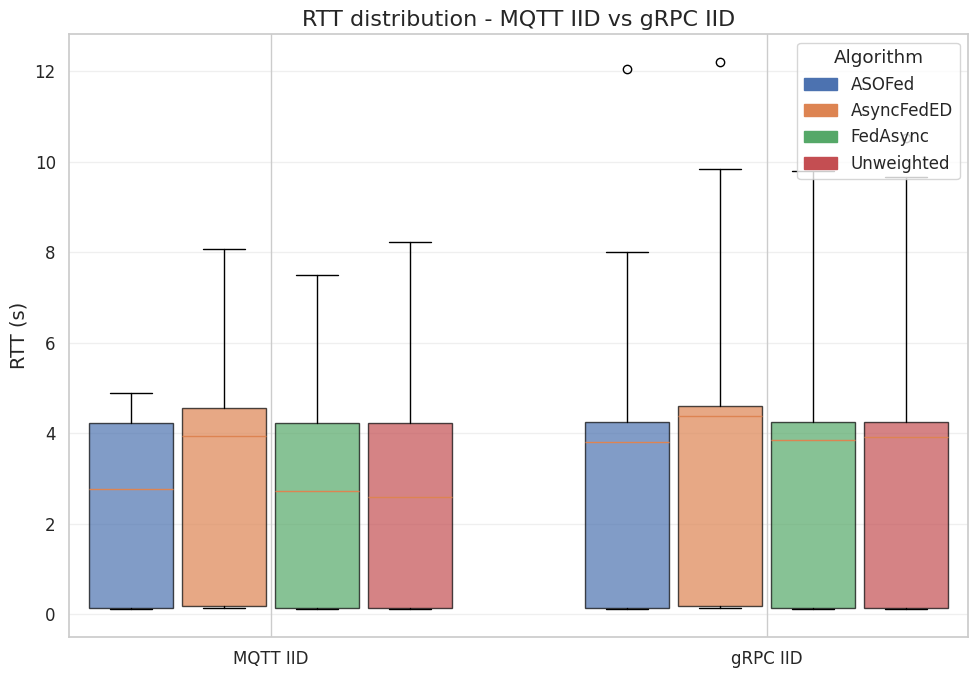

Analysis complete!


In [155]:
import os, glob, re
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ---------------------------------------------------------------------
# 1. utility
def extract_all_times(log_file):
    """Return list of float RTT values in the order they appear."""
    times = []
    try:
        with open(log_file, "r") as fh:
            for line in fh:
                m = re.search(r"Round\s+\d+,\s*time\s+for\s+.*?\s+is\s+([\d.]+)", line)
                if m:
                    times.append(float(m.group(1)))
    except FileNotFoundError:
        print(f"[warn] {log_file} missing")
    return times

def parse_file_info(path):
    """
    Mini-parser che restituisce un dizionario tipo
    {'group': 'MQTT IID', 'algorithm': 'FedAvg'}  - adatta se servono altri campi.
    """
    # esempio di path:  .../MQTT_IID/FedAvg/worker_0.log
    parts = path.split(os.sep)
    return {
        "group": parts[-3].replace("_", " "),   # MQTT_IID → MQTT IID
        "algorithm": parts[-2]
    }

# ---------------------------------------------------------------------
# 2. raccolta e filtraggio
base_path = os.getcwd()  # Use current working directory for output files
raw_time_data = {}          # {group: {algorithm: [values]}}
wanted_groups = {"MQTT IID", "gRPC IID"}

# Use existing timing_data instead of scanning log files
if 'timing_data' in globals():
    print("Using existing timing_data...")
    for group in timing_data:
        if group in wanted_groups:
            raw_time_data[group] = {}
            for algo in timing_data[group]:
                # Convert dict values to list for boxplot
                values = list(timing_data[group][algo].values())
                # Remove first 20% of the values
                k = int(len(values) * 0.2)
                trimmed = values[k:]
                if trimmed:
                    raw_time_data[group][algo] = trimmed
else:
    print("No timing_data available. Please run data collection first.")

# ---------------------------------------------------------------------
# 3. preparazione del box-plot
plt.figure(figsize=(10, 7))
box_width = 0.75
group_gap  = 1.0

positions  = []   # posizione di ogni box
box_data   = []   # i dati stessi
colors     = []   # colore per box
group_centers = {}    # posizione “centrale” di ciascun gruppo

# palette deterministica per gli algoritmi
palette = {}
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

current_pos = 1
for group in sorted(raw_time_data):
    algos = sorted(raw_time_data[group])
    start_pos = current_pos

    for algo in algos:
        # assegna colore se nuovo
        if algo not in palette:
            palette[algo] = color_cycle[len(palette) % len(color_cycle)]

        positions.append(current_pos)
        box_data.append(raw_time_data[group][algo])
        colors.append(palette[algo])
        current_pos += box_width

    # posizione centrale per label asse X
    group_centers[group] = (start_pos + current_pos - box_width) / 2
    current_pos += group_gap

# disegna boxplot
bp = plt.boxplot(box_data, positions=positions, widths=box_width*0.9,
                 patch_artist=True, showfliers=True)

for box, c in zip(bp["boxes"], colors):
    box.set(facecolor=c, alpha=0.7)

# asse X: solo le due macro-categorie
plt.xticks(list(group_centers.values()), list(group_centers.keys()), fontsize=12)
plt.ylabel("RTT (s)")
plt.title("RTT distribution - MQTT IID vs gRPC IID")

# legenda: un colore per algoritmo
legend_handles = [Patch(color=palette[a], label=a) for a in sorted(palette)]
plt.legend(handles=legend_handles, title="Algorithm", loc="upper right")

plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(base_path, "async_time_distributions_boxplot_standard.png"),
            dpi=300, bbox_inches='tight')
plt.show()

print("Analysis complete!")


/tmp/ipykernel_1499627/1061955002.py:52: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


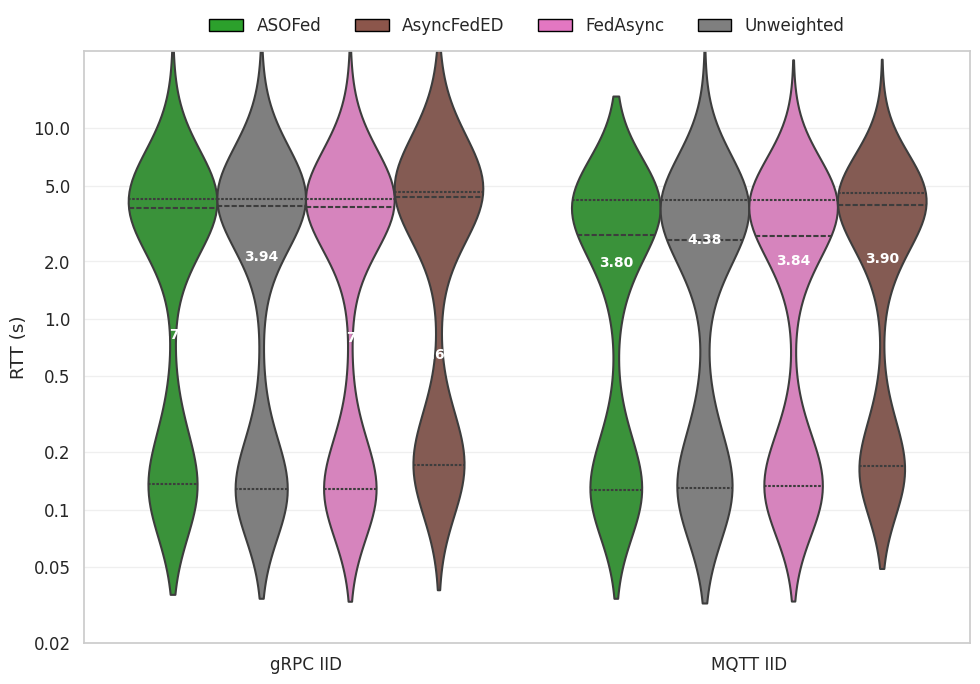

In [156]:

algo_colors = {
    "FedAvg": '#1f77b4',
    "FedAvg + CS": '#ff7f0e',
    "SCAFFOLD": '#d62728',
    "SCAFFOLD + CS": '#9467bd',
    "ASOFed": '#2ca02c',       # Green
    "AsyncFedED": '#8c564b',    # Brown
    "FedAsync": '#e377c2',      # Pink
    "Unweighted": '#7f7f7f'     # Gray
}

# ---------------------------------------------------------------------
# 3. preparazione del violin-plot con Seaborn
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --- 3a. converte raw_time_data in un DataFrame “long” --------------
records = []
for group, algos in raw_time_data.items():
    for algo, values in algos.items():
        records.extend(
            {"Group": group, "Algorithm": algo, "RTT": v}
            for v in values
        )

df = pd.DataFrame(records)

# --- 3b. palette deterministica per gli algoritmi --------------------
unique_algos = sorted(df["Algorithm"].unique())
color_cycle   = plt.rcParams["axes.prop_cycle"].by_key()["color"]
# palette       = {a: color_cycle[i % len(color_cycle)]
#                  for i, a in enumerate(unique_algos)}
palette = {a: algo_colors[a] for a in unique_algos}
# --- 3c. disegna violin-plot ----------------------------------------

df["logRTT"] = np.log10(df["RTT"])

# choose display range in seconds (no need for cut to avoid <0)
sec_min, sec_max = 0.1, 8.0
log_min, log_max = np.log10(sec_min), np.log10(sec_max)

# ----------------------------------------------------------------------
# 3. violin (KDE on logRTT, axis labeled in seconds) -------------------
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 7))



width = 0.8  # match first script width
ax = sns.violinplot(
    x="Group",
    y="logRTT",
    hue="Algorithm",
    data=df,
    palette=palette,
    # cut=0,               # niente code extrapolate
    # scale="width",       # tutte le violins hanno uguale larghezza
    inner="quartile",    # mostra mediana + quartili
    scale="width",
    width=width,
    linewidth=1.5,
    legend=False
)

# y-axis ticks (log seconds)
ticks_sec = np.array([0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10])
ax.set_ylim(np.log10(0.1), np.log10(8.0) + 0.5)
ax.set_yticks(np.log10(ticks_sec))
ax.set_yticklabels([str(t) for t in ticks_sec])

ax.set_ylabel("RTT (s)")
ax.set_xlabel("")

# Legend with fixed order
handles = [Patch(facecolor=algo_colors[a], edgecolor="black", label=a) for a in unique_algos]
ax.legend(handles=handles, loc="upper right")

# ----------------------------------------------------------------------
# Add median values as text
# ----------------------------------------------------------------------
grouped = df.groupby(["Group", "Algorithm"])["RTT"].median().reset_index()

# Map each (Protocol, Algorithm) to its x-position in the plot
# Use unique_algos derived from the dataframe for correct ordering
n_hues = len(unique_algos)
positions = {}
for i, proto in enumerate(["MQTT IID", "gRPC IID"]):
    for j, algo in enumerate(unique_algos):
        x_pos = i - 0.4 + (j + 0.5) * (0.8 / n_hues)  # center each hue in its slot
        positions[(proto, algo)] = x_pos

# Function to pick text color based on background
import matplotlib.colors as mcolors
def get_text_color(hex_color):
    r, g, b = mcolors.to_rgb(hex_color)
    brightness = (r*0.299 + g*0.587 + b*0.114)
    return "black" if brightness > 0.8 else "white"

# Add text labels
for _, row in grouped.iterrows():
    proto, algo, median_val = row["Group"], row["Algorithm"], row["RTT"]
    x = positions[(proto, algo)]
    y = np.log10(median_val-2)
    color = get_text_color(algo_colors[algo])
    ax.text(x, y - 0.0 , f"{median_val:.2f}", ha="center", va="bottom",
            color=color, fontsize=10, fontweight="bold")

ax.grid(True, axis="y", alpha=0.3)


handles = [Patch(facecolor=algo_colors[a], edgecolor="black", label=a) for a in unique_algos]
ax.legend(
    handles=handles,
    title="",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.07),
    borderaxespad=0.0,
    frameon=False,
    ncol=4
)



plt.tight_layout()
plt.savefig(os.path.join(base_path, "time_distributions_violinplot_aggregated.pdf"), dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_1499627/125294070.py:159: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


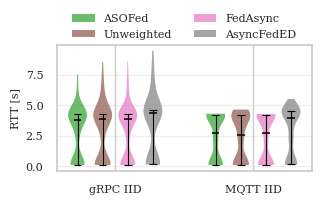

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from tqdm.auto import trange  # only for a progress bar during bootstrapping


from __future__ import annotations

import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Sequence, Optional, Literal
from matplotlib.ticker import FormatStrFormatter , MaxNLocator, MultipleLocator  # aggiungi subito dopo gli altri import
from matplotlib.ticker import FuncFormatter

def clean_tick_label(x, _):
    if x >= 1:
        return f"1"
    if x == 0.0:
        return f"0"
    return f"{x:.1f}"

# ----------------------------------------------------------------------------
# Matplotlib configuration ----------------------------------------------------
# ----------------------------------------------------------------------------
FONTSIZE = 8
plt.rc("text", usetex=False)
plt.rc("font", family="serif")
plt.rcParams.update({
    "font.size": FONTSIZE,
    "axes.titlesize": FONTSIZE,
    "axes.labelsize": FONTSIZE,
    "xtick.labelsize": FONTSIZE,
    "ytick.labelsize": FONTSIZE,
    "legend.fontsize": FONTSIZE,
    "hatch.linewidth": 1.0,
})


def get_figsize(columnwidth: float, width_frac: float = 0.5,
                height_frac: float = (5.0 ** 0.5 - 1.0) / 1.8) -> list[float]:
    inch_per_pt = 1.0 / 72.27
    fig_w = columnwidth * width_frac * inch_per_pt
    fig_h = fig_w * height_frac
    return [fig_w, fig_h]


# Assuming your data structure is similar to what seaborn expects
# df with columns: 'Group', 'RTT', 'Algorithm'

# First, organize the data by group and algorithm
groups = df['Group'].unique()
algorithms = df['Algorithm'].unique()

# Create figure and axis with reduced width
fig, ax = plt.subplots(figsize=get_figsize(456,height_frac=0.7),layout='constrained')  # Reduced from 12 to 10

# Set up positions for violins
positions = []
labels = []
colors = []
    # "ASOFed": '#2ca02c',       # Green
    # "AsyncFedED": '#8c564b',    # Brown
    # "FedAsync": '#e377c2',      # Pink
    # "Unweighted": '#7f7f7f'     # Gray
# Define your color palette
palette_colors = ['#2ca02c', '#8c564b', '#e377c2', '#7f7f7f']  # Adjust as needed

violin_parts_list = []
position = 0
group_positions = {}

for i, group in enumerate(groups):
    group_start = position
    
    for j, algorithm in enumerate(algorithms):
        # Filter data for this group and algorithm
        data_subset = df[(df['Group'] == group) & (df['Algorithm'] == algorithm)]['RTT'].values
        
        if len(data_subset) > 0:
            # Create violin plot for this subset with narrower width
            p5, p95 = np.percentile(data_subset, [1, 99])  # Keep middle 90% of data
            trimmed_data = data_subset[(data_subset >= p5) & (data_subset <= p95)]

            parts = ax.violinplot(
                [trimmed_data],
                positions=[position],
                widths=0.6,  # Reduced from 0.7 to 0.6 for tighter spacing
                showmeans=False,
                showmedians=False,
                showextrema=False,
            )
            
            # Store parts for later styling
            violin_parts_list.append((parts, palette_colors[j % len(palette_colors)]))
            
            # Calculate quartiles and whiskers
            q1, median, q3 = np.percentile(data_subset, [25, 50, 75])
            
            # Add quartile lines with slightly narrower width
            ax.hlines(q1, position - 0.12, position + 0.12, color='black', linestyle='-', lw=0.8)
            ax.hlines(median, position - 0.12, position + 0.12, color='black', linestyle='-', lw=1.1)
            ax.hlines(q3, position - 0.12, position + 0.12, color='black', linestyle='-', lw=0.8)
            
            # Add vertical line connecting quartiles
            ax.vlines(position, q1, q3, color='black', linestyle='-', lw=0.8)
            
            positions.append(position)
            position += 0.8  # Reduced spacing within groups (was 1)
    
    # Store group center position for x-axis labels
    group_end = position - 0.8
    group_positions[group] = (group_start + group_end) / 2
    
    # Add larger space between groups
    position += 1.2  # Increased from 0.5 to 1.2 for clearer group separation

# Style the violin plots
for parts, color in violin_parts_list:
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('none')
        pc.set_alpha(0.7)
        pc.set_linewidth(1.2)

# Set x-axis labels and ticks
ax.set_xticks(list(group_positions.values()))
ax.set_xticklabels(list(group_positions.keys()))

# Add legend for algorithms
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=palette_colors[i % len(palette_colors)], 
                         alpha=0.7, 
                         edgecolor='none',
                         label=algorithm) 
                   for i, algorithm in enumerate(algorithms)]

ax.legend(handles=legend_elements,
    title="",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.28),
    borderaxespad=0.0,
    frameon=False,
    ncol=2)


# Labels and styling
ax.set_xlabel('')
ax.set_ylabel('RTT [s]')
ax.grid(True, alpha=0.3, axis='y')
# ax.set_yscale('log')

plt.tight_layout()
plt.savefig(os.path.join(base_path, "time_distributions_violinplot_async.pdf"), dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_1499627/1771849129.py:159: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


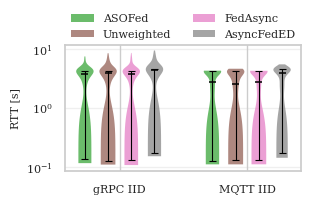

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from tqdm.auto import trange  # only for a progress bar during bootstrapping


from __future__ import annotations

import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Sequence, Optional, Literal
from matplotlib.ticker import FormatStrFormatter , MaxNLocator, MultipleLocator  # aggiungi subito dopo gli altri import
from matplotlib.ticker import FuncFormatter

def clean_tick_label(x, _):
    if x >= 1:
        return f"1"
    if x == 0.0:
        return f"0"
    return f"{x:.1f}"

# ----------------------------------------------------------------------------
# Matplotlib configuration ----------------------------------------------------
# ----------------------------------------------------------------------------
FONTSIZE = 8
plt.rc("text", usetex=False)
plt.rc("font", family="serif")
plt.rcParams.update({
    "font.size": FONTSIZE,
    "axes.titlesize": FONTSIZE,
    "axes.labelsize": FONTSIZE,
    "xtick.labelsize": FONTSIZE,
    "ytick.labelsize": FONTSIZE,
    "legend.fontsize": FONTSIZE,
    "hatch.linewidth": 1.0,
})


def get_figsize(columnwidth: float, width_frac: float = 0.5,
                height_frac: float = (5.0 ** 0.5 - 1.0) / 1.8) -> list[float]:
    inch_per_pt = 1.0 / 72.27
    fig_w = columnwidth * width_frac * inch_per_pt
    fig_h = fig_w * height_frac
    return [fig_w, fig_h]


# Assuming your data structure is similar to what seaborn expects
# df with columns: 'Group', 'RTT', 'Algorithm'

# First, organize the data by group and algorithm
groups = df['Group'].unique()
algorithms = df['Algorithm'].unique()

# Create figure and axis with reduced width
fig, ax = plt.subplots(figsize=get_figsize(456,height_frac=0.7),layout='constrained')  # Reduced from 12 to 10

# Set up positions for violins
positions = []
labels = []
colors = []
    # "ASOFed": '#2ca02c',       # Green
    # "AsyncFedED": '#8c564b',    # Brown
    # "FedAsync": '#e377c2',      # Pink
    # "Unweighted": '#7f7f7f'     # Gray
# Define your color palette
palette_colors = ['#2ca02c', '#8c564b', '#e377c2', '#7f7f7f']  # Adjust as needed

violin_parts_list = []
position = 0
group_positions = {}

for i, group in enumerate(groups):
    group_start = position
    
    for j, algorithm in enumerate(algorithms):
        # Filter data for this group and algorithm
        data_subset = df[(df['Group'] == group) & (df['Algorithm'] == algorithm)]['RTT'].values
        
        if len(data_subset) > 0:
            # Create violin plot for this subset with narrower width
            p5, p95 = np.percentile(data_subset, [1, 99])  # Keep middle 90% of data
            trimmed_data = data_subset[(data_subset >= p5) & (data_subset <= p95)]

            parts = ax.violinplot(
                [trimmed_data],
                positions=[position],
                widths=0.6,  # Reduced from 0.7 to 0.6 for tighter spacing
                showmeans=False,
                showmedians=False,
                showextrema=False,
            )
            
            # Store parts for later styling
            violin_parts_list.append((parts, palette_colors[j % len(palette_colors)]))
            
            # Calculate quartiles and whiskers
            q1, median, q3 = np.percentile(data_subset, [25, 50, 75])
            
            # Add quartile lines with slightly narrower width
            ax.hlines(q1, position - 0.12, position + 0.12, color='black', linestyle='-', lw=0.8)
            ax.hlines(median, position - 0.12, position + 0.12, color='black', linestyle='-', lw=1.1)
            ax.hlines(q3, position - 0.12, position + 0.12, color='black', linestyle='-', lw=0.8)
            
            # Add vertical line connecting quartiles
            ax.vlines(position, q1, q3, color='black', linestyle='-', lw=0.8)
            
            positions.append(position)
            position += 0.8  # Reduced spacing within groups (was 1)
    
    # Store group center position for x-axis labels
    group_end = position - 0.8
    group_positions[group] = (group_start + group_end) / 2
    
    # Add larger space between groups
    position += 1.2  # Increased from 0.5 to 1.2 for clearer group separation

# Style the violin plots
for parts, color in violin_parts_list:
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('none')
        pc.set_alpha(0.7)
        pc.set_linewidth(1.2)

# Set x-axis labels and ticks
ax.set_xticks(list(group_positions.values()))
ax.set_xticklabels(list(group_positions.keys()))

# Add legend for algorithms
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=palette_colors[i % len(palette_colors)], 
                         alpha=0.7, 
                         edgecolor='none',
                         label=algorithm) 
                   for i, algorithm in enumerate(algorithms)]

ax.legend(handles=legend_elements,
    title="",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.28),
    borderaxespad=0.0,
    frameon=False,
    ncol=2)


# Labels and styling
ax.set_xlabel('')
ax.set_ylabel('RTT [s]')
ax.grid(True, alpha=0.3, axis='y')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "time_distributions_violinplot_async_log.pdf"), dpi=300, bbox_inches='tight')
plt.show()